<a href="https://colab.research.google.com/github/elainefortes/Classifica-o-e-Riscos-de-Reentradas-em-Sat-lites-Globais/blob/main/Satelitesv7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# MÓDULO 1 — MONTAGEM DO DRIVE, IMPORTS E CONFIGURAÇÕES GERAIS

from google.colab import drive
drive.mount('/content/drive')

import os
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Configurações visuais
warnings.filterwarnings("ignore")
sns.set_style("whitegrid")

plt.rcParams.update({
    "figure.dpi": 120,
    "axes.titlesize": 16,
    "axes.labelsize": 14,
    "xtick.labelsize": 12,
    "ytick.labelsize": 12,
    "legend.fontsize": 12
})

# Diretório de saída
output_dir = "/content/figuras_artigo"
os.makedirs(output_dir, exist_ok=True)

# Caminho do CSV
CAMINHO_CSV = "/content/drive/MyDrive/Aeroespacial/active_satellites.csv"

print("Ambiente inicializado com sucesso.")
print(f"Diretório de saída: {output_dir}")
print(f"Arquivo base: {CAMINHO_CSV}")

# Leitura do CSV e exibição das primeiras linhas
if os.path.exists(CAMINHO_CSV):
    df = pd.read_csv(CAMINHO_CSV)
    print("\nAs 10 primeiras linhas do arquivo carregado:")
    print(df.head(10))
else:
    print(f"Arquivo não encontrado no caminho especificado: {CAMINHO_CSV}")


Mounted at /content/drive
Ambiente inicializado com sucesso.
Diretório de saída: /content/figuras_artigo
Arquivo base: /content/drive/MyDrive/Aeroespacial/active_satellites.csv

As 10 primeiras linhas do arquivo carregado:
          OBJECT_NAME  OBJECT_ID                       EPOCH  MEAN_MOTION  \
0         CALSPHERE 1  1964-063C  2025-10-02T04:06:18.711360    13.762216   
1         CALSPHERE 2  1964-063E  2025-10-01T16:17:21.745824    13.528735   
2               LCS 1  1965-034C  2025-10-02T01:44:08.384928     9.893093   
3           TEMPSAT 1  1965-065E  2025-10-02T02:23:12.238944    13.335733   
4        CALSPHERE 4A  1965-065H  2025-10-02T03:02:33.709056    13.362198   
5  OPS 5712 (P/L 160)  1967-053A  2025-10-02T03:29:10.908960    14.723575   
6               LES-5  1967-066E  2025-09-30T19:59:34.537632     1.094261   
7          SURCAL 159  1967-053F  2025-10-02T01:58:11.958240    13.995097   
8  OPS 5712 (P/L 153)  1967-053H  2025-10-02T02:39:19.624320    13.967713   
9      

Arquivo carregado com 12,810 registros e 17 colunas.
Aviso: coluna 'ALTITUDE_KM' ausente. Calculando a partir de MEAN_MOTION e ECCENTRICITY.
Figura salva em: /content/figuras_artigo/pais.png


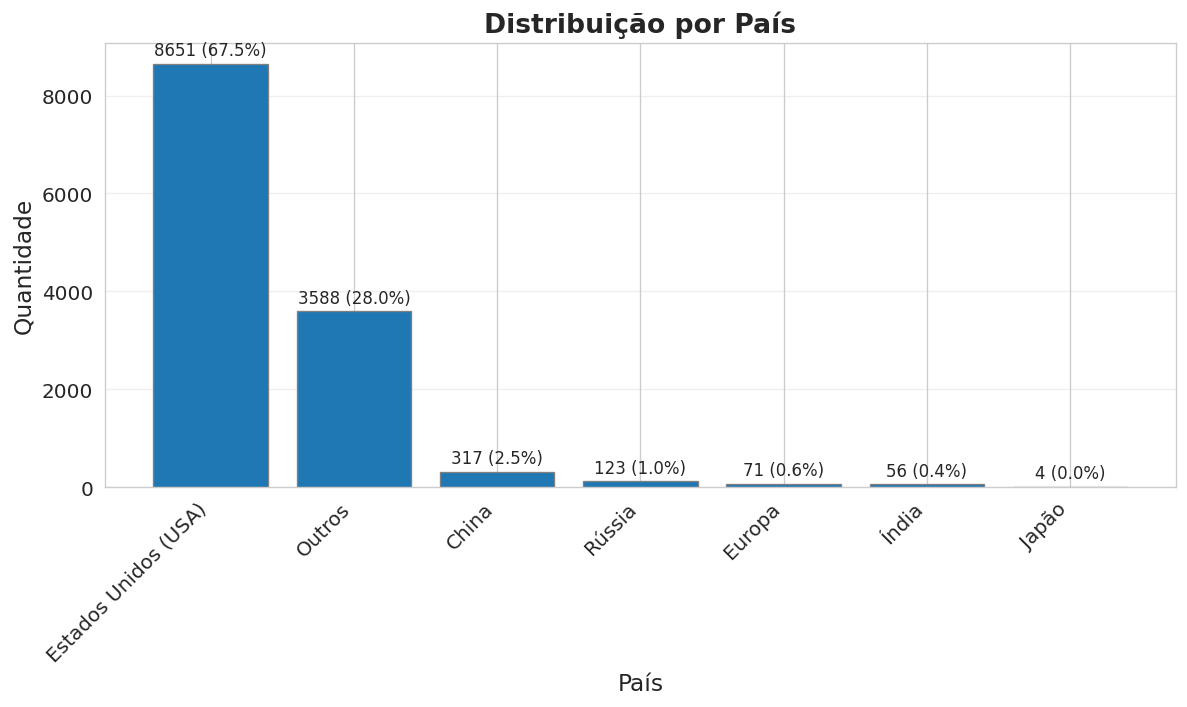

Figura salva em: /content/figuras_artigo/faixa_inclinacao.png


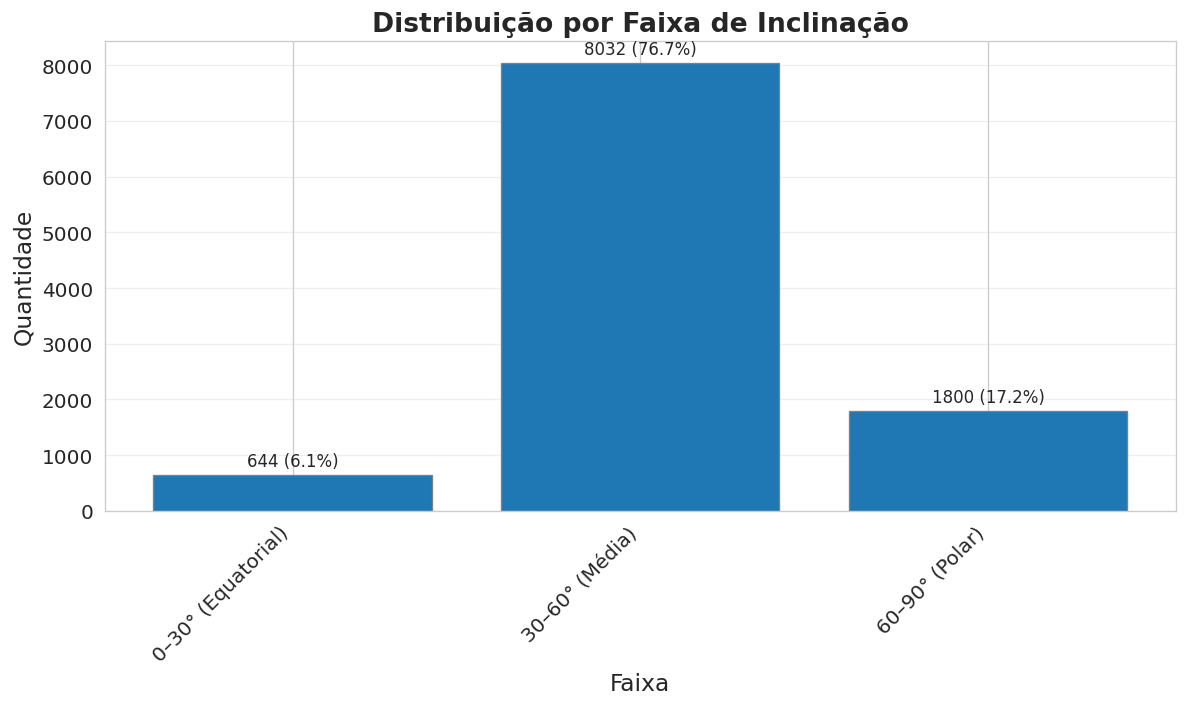

Figura salva em: /content/figuras_artigo/regiao_latitudinal.png


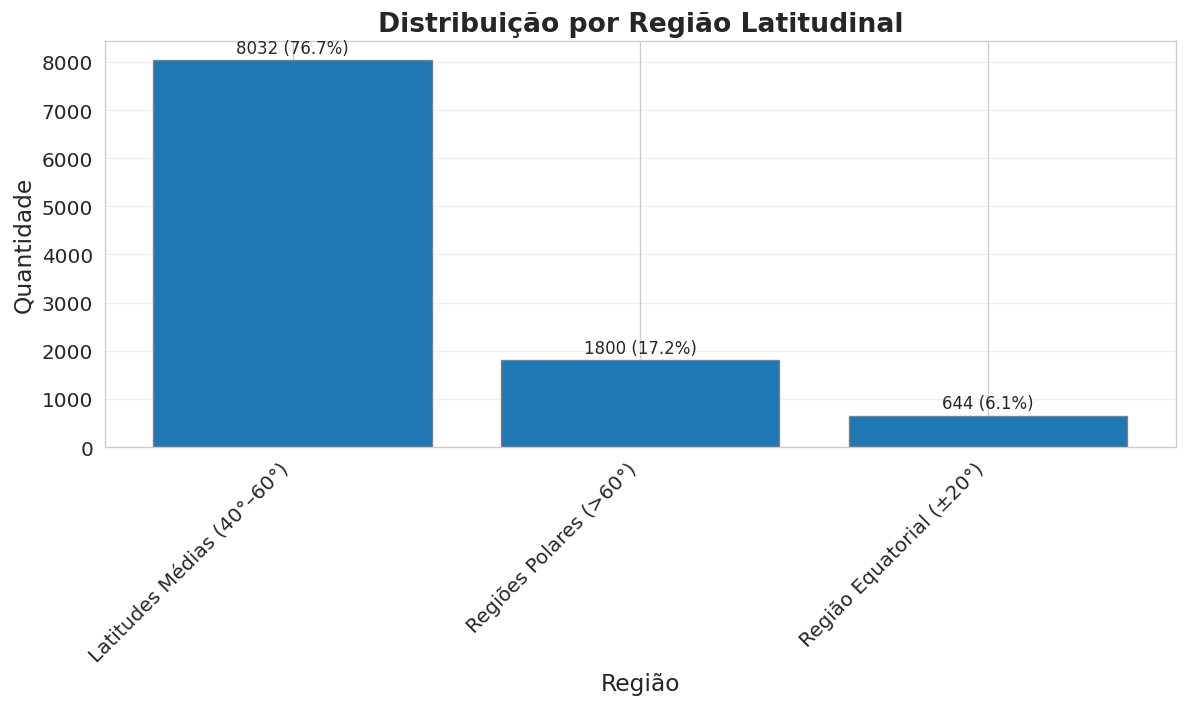

Figura salva em: /content/figuras_artigo/excentricidade.png


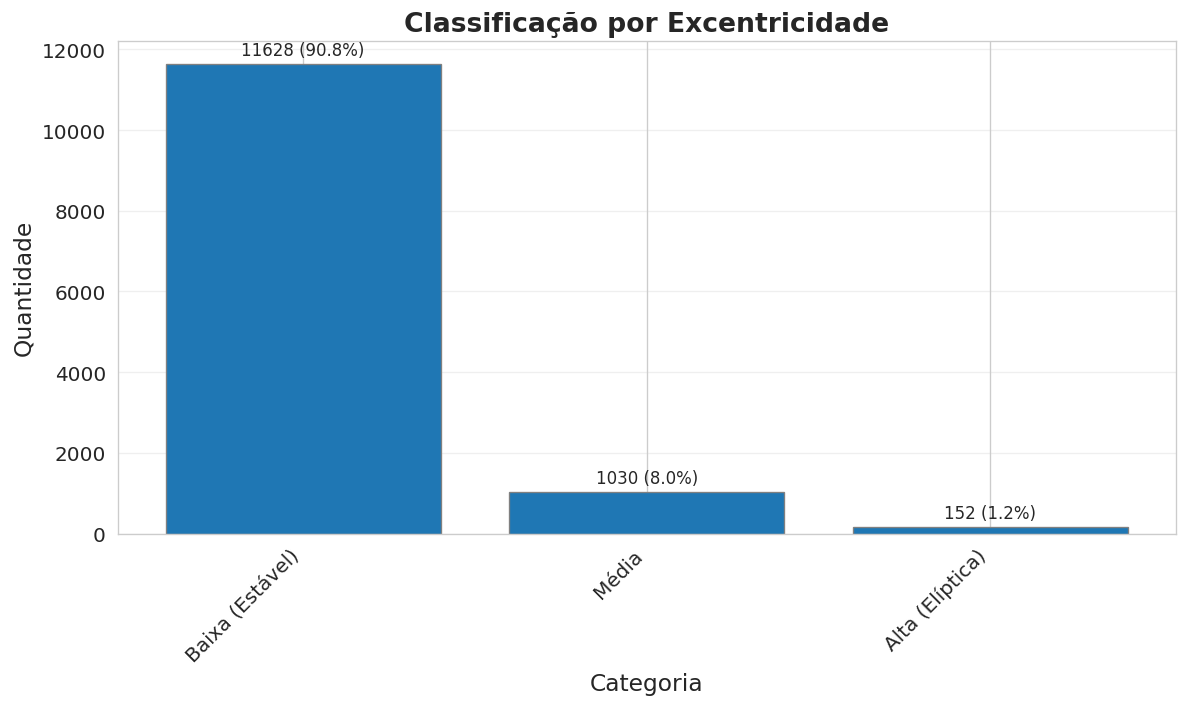

Figura salva em: /content/figuras_artigo/bstar.png


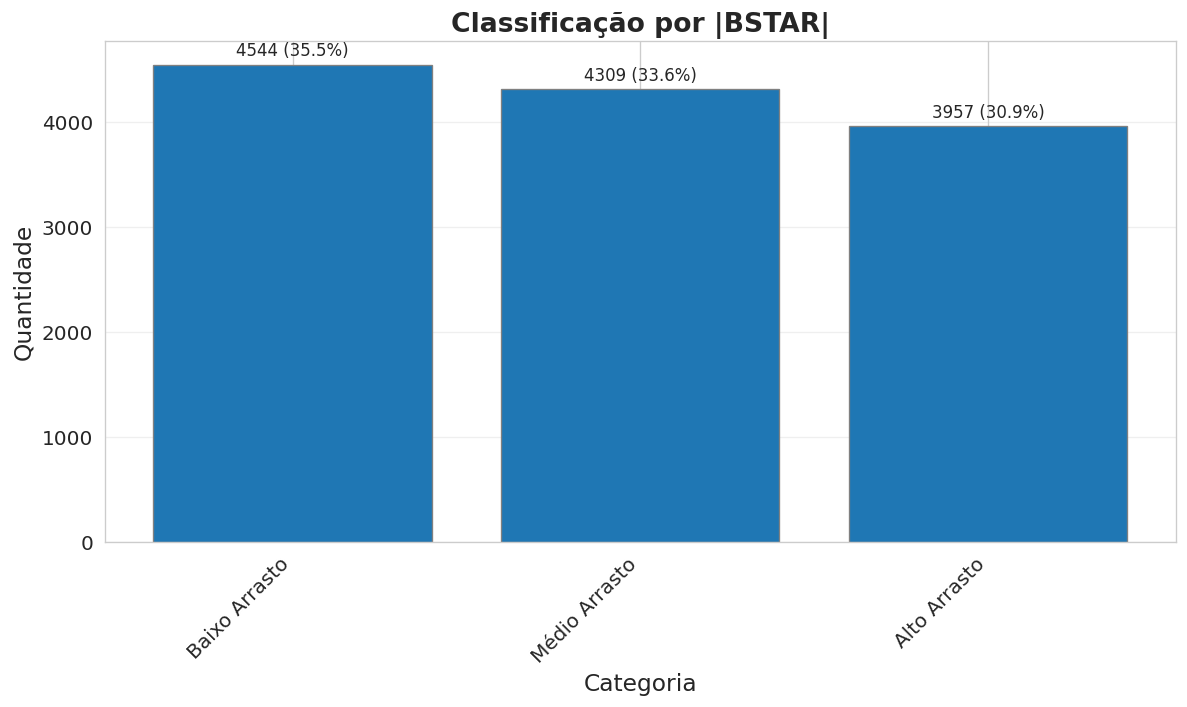

Figura salva em: /content/figuras_artigo/tipo_satelite.png


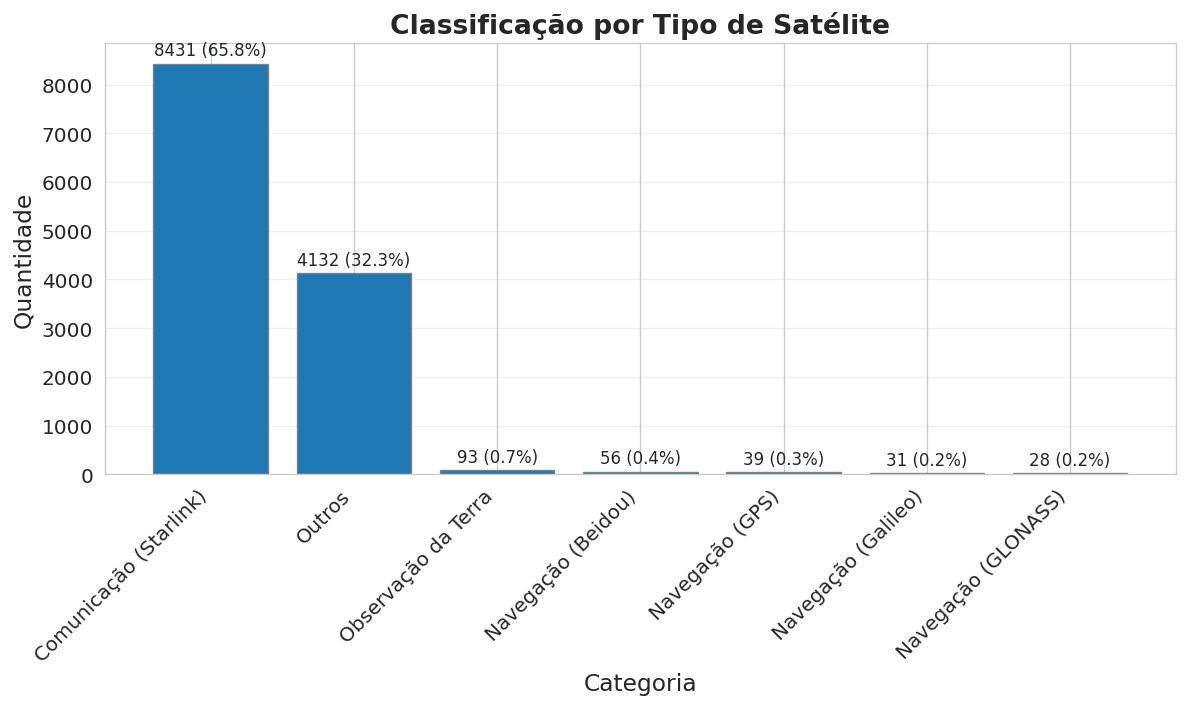

Figura salva em: /content/figuras_artigo/constelacoes.png


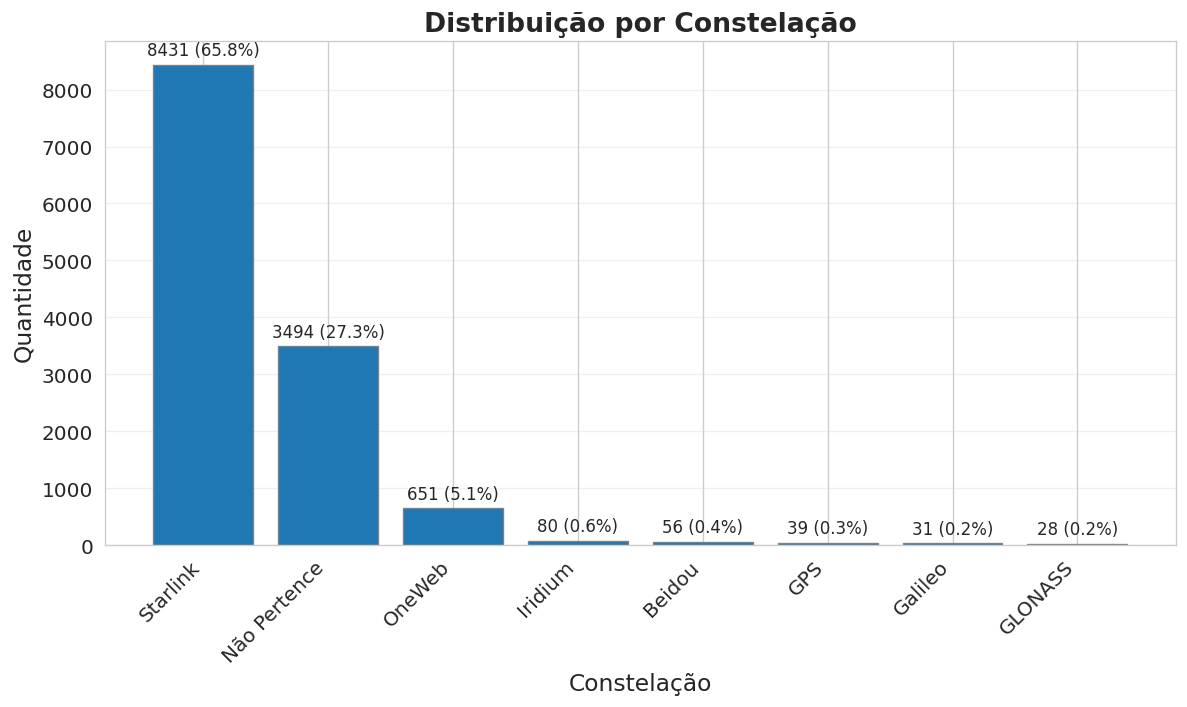

Figura salva em: /content/figuras_artigo/faixa_orbital.png


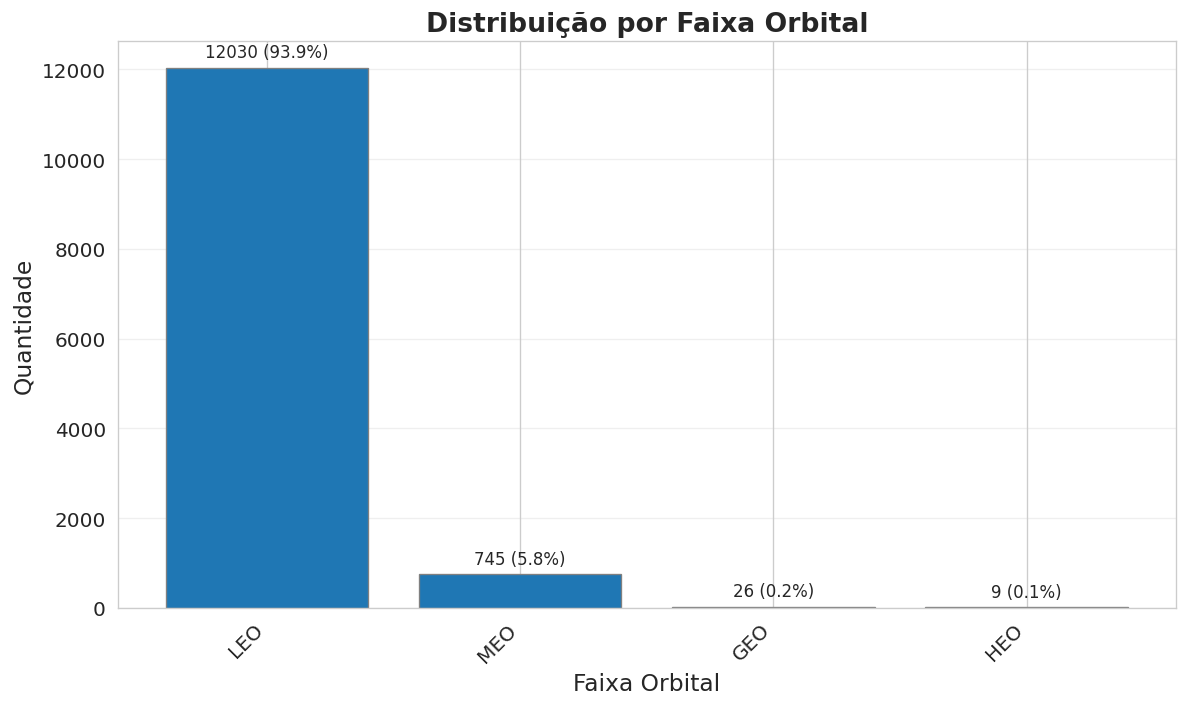

FAIXA_ORBITA
LEO    12030.0
MEO      745.0
GEO       26.0
HEO        9.0
Name: count, dtype: float64

In [ ]:
# MÓDULO 2 — ANÁLISES DESCRITIVAS COMPLETAS

# Carregamento do CSV
df = pd.read_csv(CAMINHO_CSV)
print(f"Arquivo carregado com {len(df):,} registros e {len(df.columns)} colunas.")

# Garantia de colunas essenciais

# ALTITUDE_KM
if "ALTITUDE_KM" not in df.columns:
    print("Aviso: coluna 'ALTITUDE_KM' ausente. Calculando a partir de MEAN_MOTION e ECCENTRICITY.")

    MU = 3.986004418e14
    R_TERRA = 6378137.0
    SEG_POR_DIA = 86400.0

    def _a(n_rev_dia):
        if pd.isna(n_rev_dia) or n_rev_dia <= 0:
            return np.nan
        n_rad_s = n_rev_dia * 2*np.pi / SEG_POR_DIA
        return (MU / n_rad_s**2)**(1/3)

    def _alt(a_m, e):
        if pd.isna(a_m) or pd.isna(e):
            return np.nan
        return (a_m*(1-e) - R_TERRA)/1000

    df["SEMI_EIXO_MAIOR_M"] = df["MEAN_MOTION"].apply(_a)
    df["ALTITUDE_KM"] = df.apply(lambda r: _alt(r["SEMI_EIXO_MAIOR_M"], r.get("ECCENTRICITY", np.nan)), axis=1)

# BSTAR
if "BSTAR" not in df.columns:
    print("Aviso: coluna 'BSTAR' ausente. Criando BSTAR=0.0.")
    df["BSTAR"] = 0.0

df["ABS_BSTAR"] = df["BSTAR"].abs()

# Função de gráfico de barras
def plot_barras(series, titulo, xlabel, ylabel, top_n=None,
                salvar=None, cor="#1f77b4", legenda=None):
    s = pd.Series(series).fillna(0)
    s = s[s > 0]

    if top_n:
        s_sorted = s.sort_values(ascending=False)
        s = s_sorted.head(top_n)
        outros = s_sorted.iloc[top_n:].sum()
        if outros > 0:
            s["Outros"] = outros

    total = s.sum()

    fig, ax = plt.subplots(figsize=(10, 6))
    bars = ax.bar(s.index.astype(str), s.values, color=cor,
                  edgecolor="gray", linewidth=0.8)

    ax.set_title(titulo, fontsize=16, fontweight="bold")
    ax.set_xlabel(xlabel, fontsize=14)
    ax.set_ylabel(ylabel, fontsize=14)
    plt.xticks(rotation=45, ha="right")
    plt.grid(axis="y", alpha=0.3)

    y_offset = s.max()*0.02

    for bar, val in zip(bars, s.values):
        pct = (val/total*100) if total>0 else 0
        ax.text(bar.get_x()+bar.get_width()/2,
                val + y_offset,
                f"{int(val)} ({pct:.1f}%)",
                ha="center", fontsize=10)

    plt.tight_layout()

    if salvar:
        path_png = f"{output_dir}/{salvar}.png"
        plt.savefig(path_png, dpi=400, bbox_inches="tight")
        print(f"Figura salva em: {path_png}")

    plt.show()
    return s

# 1. Distribuição por País
pais_padroes = {
    "Estados Unidos (USA)": ["USA","STARLINK","GPS","NAVSTAR","GOES","LANDSAT","SPACEX","IRIDIUM"],
    "Rússia": ["COSMOS","GLONASS","MOLNIYA"],
    "China": ["BEIDOU","GAOFEN","SHIJIAN","YAOGAN"],
    "Japão": ["HIMAWARI","QZSS","ALOS"],
    "Europa": ["GALILEO","SENTINEL","METOP","EUTELSAT"],
    "Índia": ["INSAT","IRNSS","CARTOSAT","GSAT"],
    "Outros": []
}

def classificar_pais(obj):
    u = str(obj).upper()
    for pais, lista in pais_padroes.items():
        if any(k in u for k in lista):
            return pais
    return "Outros"

df["PAIS"] = df["OBJECT_NAME"].apply(classificar_pais)

plot_barras(
    df["PAIS"].value_counts(),
    "Distribuição por País",
    "País",
    "Quantidade",
    top_n=8,
    salvar="pais"
)

# 2. Distribuição por Faixa de Inclinação
df["Faixa_Inclinacao"] = pd.cut(
    df["INCLINATION"],
    bins=[0, 30, 60, 90],
    labels=["0–30° (Equatorial)", "30–60° (Média)", "60–90° (Polar)"]
)

plot_barras(
    df["Faixa_Inclinacao"].value_counts().sort_index(),
    "Distribuição por Faixa de Inclinação",
    "Faixa",
    "Quantidade",
    salvar="faixa_inclinacao"
)

# 3. Distribuição por Região Latitudinal
def faixa_para_regiao(faixa):
    faixa = str(faixa)
    if "0–30" in faixa:
        return "Região Equatorial (±20°)"
    if "30–60" in faixa:
        return "Latitudes Médias (40°–60°)"
    return "Regiões Polares (>60°)"

df["REGIAO"] = df["Faixa_Inclinacao"].apply(faixa_para_regiao)

plot_barras(
    df["REGIAO"].value_counts(),
    "Distribuição por Região Latitudinal",
    "Região",
    "Quantidade",
    salvar="regiao_latitudinal"
)

# 4. Classificação por Excentricidade
def classificar_ecc(e):
    if e < 0.001: return "Baixa (Estável)"
    if e < 0.01:  return "Média"
    return "Alta (Elíptica)"

df["ECC_CLASS"] = df["ECCENTRICITY"].apply(classificar_ecc)

plot_barras(
    df["ECC_CLASS"].value_counts(),
    "Classificação por Excentricidade",
    "Categoria",
    "Quantidade",
    salvar="excentricidade"
)

# 5. Classificação por BSTAR
df["CLASSE_BSTAR"] = df["ABS_BSTAR"].apply(
    lambda b: "Baixo Arrasto" if b<0.0001 else
              "Médio Arrasto" if b<0.001 else
              "Alto Arrasto"
)

ordem_bstar = ["Baixo Arrasto", "Médio Arrasto", "Alto Arrasto"]

plot_barras(
    df["CLASSE_BSTAR"].value_counts().reindex(ordem_bstar),
    "Classificação por |BSTAR|",
    "Categoria",
    "Quantidade",
    salvar="bstar"
)

# 6. Classificação por Tipo de Satélite
def classificar_tipo(obj):
    u = str(obj).upper()
    if "STARLINK" in u: return "Comunicação (Starlink)"
    if "GPS" in u or "NAVSTAR" in u: return "Navegação (GPS)"
    if "GLONASS" in u: return "Navegação (GLONASS)"
    if "GALILEO" in u: return "Navegação (Galileo)"
    if "BEIDOU" in u: return "Navegação (Beidou)"
    if any(k in u for k in ["SENTINEL","LANDSAT","GAOFEN"]): return "Observação da Terra"
    return "Outros"

df["TIPO_SATELITE"] = df["OBJECT_NAME"].apply(classificar_tipo)

plot_barras(
    df["TIPO_SATELITE"].value_counts(),
    "Classificação por Tipo de Satélite",
    "Categoria",
    "Quantidade",
    top_n=7,
    salvar="tipo_satelite"
)

# 7. Distribuição por Constelação
def classificar_constelacao(obj):
    u = str(obj).upper()
    if "STARLINK" in u: return "Starlink"
    if "ONEWEB" in u: return "OneWeb"
    if "IRIDIUM" in u: return "Iridium"
    if "GPS" in u or "NAVSTAR" in u: return "GPS"
    if "GLONASS" in u: return "GLONASS"
    if "GALILEO" in u: return "Galileo"
    if "BEIDOU" in u: return "Beidou"
    return "Não Pertence"

df["CONSTELACAO"] = df["OBJECT_NAME"].apply(classificar_constelacao)

plot_barras(
    df["CONSTELACAO"].value_counts(),
    "Distribuição por Constelação",
    "Constelação",
    "Quantidade",
    top_n=10,
    salvar="constelacoes"
)

# 8. Distribuição por Faixa Orbital
def classificar_faixa(h):
    if pd.isna(h):
        return "Desconhecido"
    if h < 2000:
        return "LEO"
    if h < 35786:
        return "MEO"
    if abs(h - 35786) <= 300:
        return "GEO"
    return "HEO"

df["FAIXA_ORBITA"] = df["ALTITUDE_KM"].apply(classificar_faixa)

ordem_faixa = ["LEO", "MEO", "GEO", "HEO", "Desconhecido"]

plot_barras(
    df["FAIXA_ORBITA"].value_counts().reindex(ordem_faixa),
    "Distribuição por Faixa Orbital",
    "Faixa Orbital",
    "Quantidade",
    salvar="faixa_orbital"
)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.8/11.8 MB 70.2 MB/s eta 0:00:00
Contagem de satélites por região:
 - Latitudes Médias (40°–60°): 7894
 - Regiões Polares (>75°): 3363
 - Latitudes Subpolares (60°–75°): 771
 - Região Equatorial (±20°): 615
 - Latitudes Tropicais/Subtropicais (20°–40°): 167


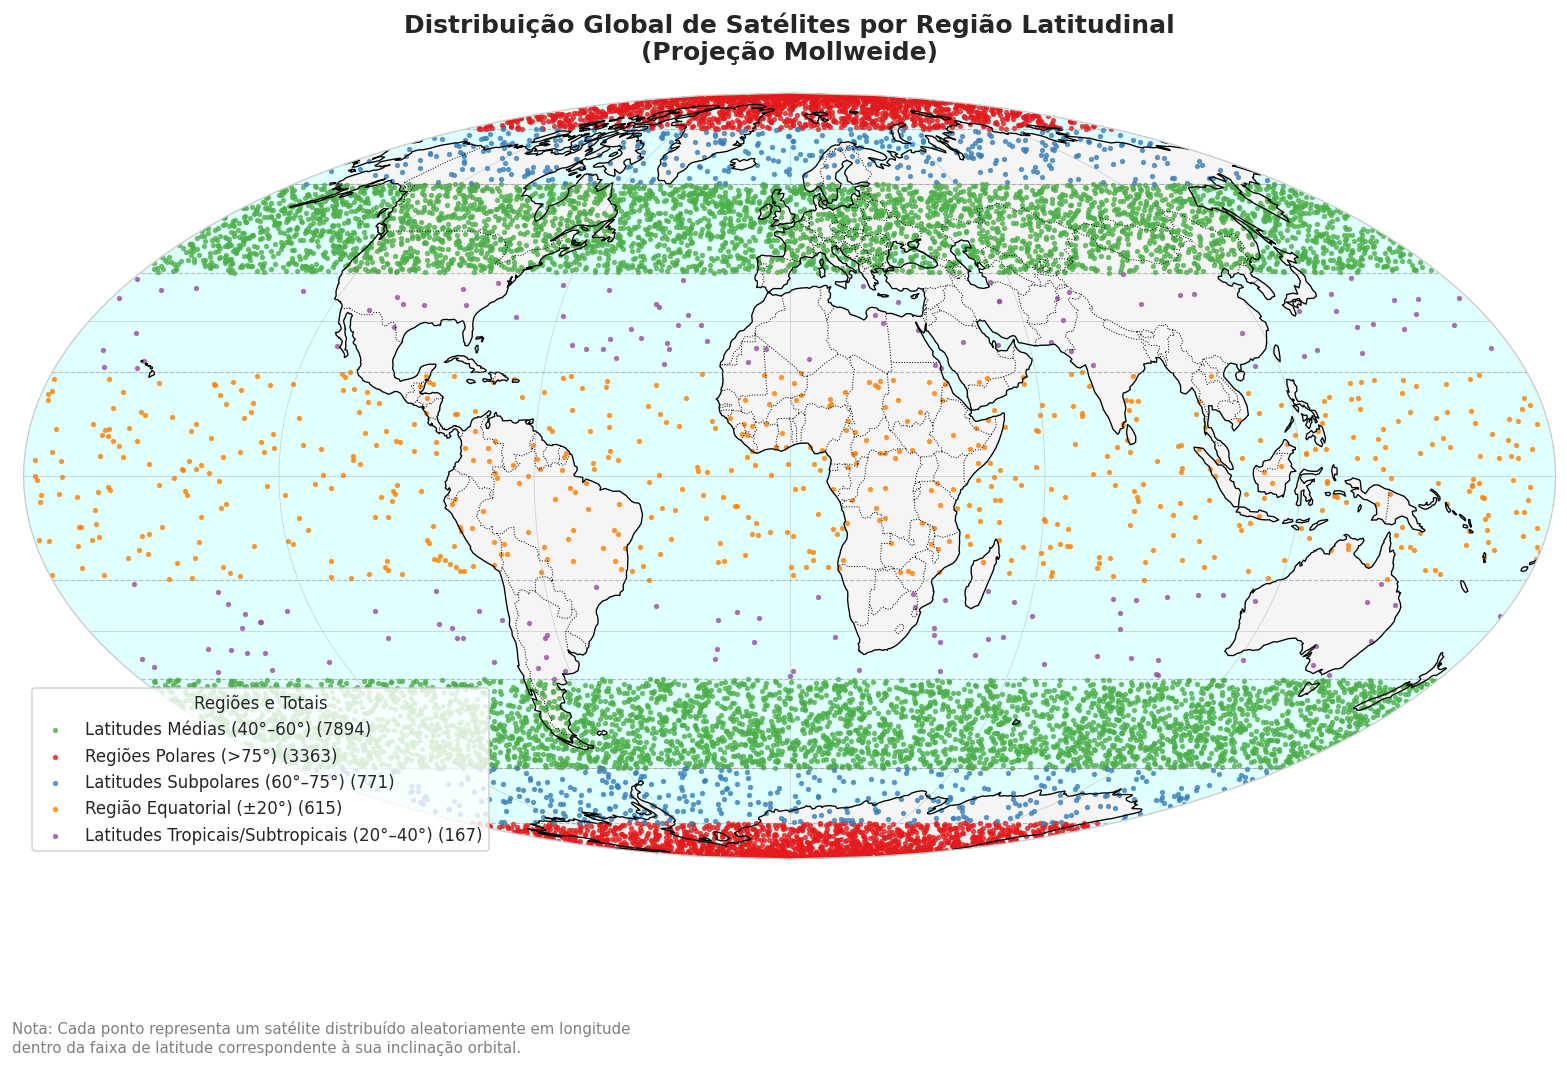

In [ ]:
# MÓDULO 3 — MAPA GLOBAL POR REGIÕES LATITUDINAIS (CARTOPY)

!pip install cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np
import matplotlib.pyplot as plt

# Classificação por inclinação orbital
def inclinacao_para_regiao(incl):
    if incl <= 20:
        return "Região Equatorial (±20°)"
    elif incl <= 40:
        return "Latitudes Tropicais/Subtropicais (20°–40°)"
    elif incl <= 60:
        return "Latitudes Médias (40°–60°)"
    elif incl <= 75:
        return "Latitudes Subpolares (60°–75°)"
    else:
        return "Regiões Polares (>75°)"

df['Regiao'] = df['INCLINATION'].apply(inclinacao_para_regiao)

# Contagem por região
regioes = df['Regiao'].value_counts().to_dict()
print("Contagem de satélites por região:")
for r, v in regioes.items():
    print(f" - {r}: {v}")

# Faixas de latitude para o mapa
faixas_lat = {
    "Regiões Polares (>75°)": [(75, 90), (-90, -75)],
    "Latitudes Subpolares (60°–75°)": [(60, 75), (-75, -60)],
    "Latitudes Médias (40°–60°)": [(40, 60), (-60, -40)],
    "Latitudes Tropicais/Subtropicais (20°–40°)": [(20, 40), (-40, -20)],
    "Região Equatorial (±20°)": [(-20, 20)]
}

# Paleta de cores
cores = {
    "Regiões Polares (>75°)": "#e41a1c",
    "Latitudes Subpolares (60°–75°)": "#377eb8",
    "Latitudes Médias (40°–60°)": "#4daf4a",
    "Latitudes Tropicais/Subtropicais (20°–40°)": "#984ea3",
    "Região Equatorial (±20°)": "#ff7f00"
}

# Plotagem
fig = plt.figure(figsize=(16, 10))
ax = plt.axes(projection=ccrs.Mollweide())

ax.add_feature(cfeature.LAND, facecolor='whitesmoke')
ax.add_feature(cfeature.OCEAN, facecolor='lightcyan')
ax.add_feature(cfeature.COASTLINE, linewidth=0.8)
ax.add_feature(cfeature.BORDERS, linestyle=':', linewidth=0.6)

# Linhas de latitude
for lat in [-75, -60, -40, -20, 20, 40, 60, 75]:
    lons = np.linspace(-180, 180, 500)
    lats = np.full_like(lons, lat)
    ax.plot(
        lons, lats,
        transform=ccrs.PlateCarree(),
        color='gray',
        linestyle='--',
        linewidth=0.7,
        alpha=0.5
    )

# Distribuição dos pontos
np.random.seed(42)
for regiao, contagem in regioes.items():
    latitudes, longitudes = [], []
    faixas = faixas_lat[regiao]

    n_faixas = len(faixas)
    sat_por_faixa = [contagem // n_faixas] * n_faixas

    for i in range(contagem % n_faixas):
        sat_por_faixa[i] += 1

    for (lat_min, lat_max), n_sats in zip(faixas, sat_por_faixa):
        lats = np.random.uniform(lat_min, lat_max, n_sats)
        lons = np.random.uniform(-180, 180, n_sats)
        latitudes.extend(lats)
        longitudes.extend(lons)

    ax.scatter(
        longitudes,
        latitudes,
        s=5,
        color=cores[regiao],
        alpha=0.7,
        transform=ccrs.PlateCarree(),
        label=f"{regiao} ({contagem})"
    )

ax.set_global()
ax.gridlines(draw_labels=False, linewidth=0.5, color='gray', alpha=0.3)

plt.title(
    "Distribuição Global de Satélites por Região Latitudinal\n(Projeção Mollweide)",
    fontsize=15,
    fontweight='bold',
    pad=20
)

plt.legend(
    title="Regiões e Totais",
    loc='lower left',
    fontsize=10,
    frameon=True
)

texto = (
    "Nota: Cada ponto representa um satélite distribuído aleatoriamente em longitude\n"
    "dentro da faixa de latitude correspondente à sua inclinação orbital."
)

plt.gcf().text(0.02, 0.02, texto, fontsize=9, color='gray')

plt.tight_layout(pad=3.0, rect=[0, 0, 0.85, 1])
plt.show()


Iniciando classificação GEO.
Colunas necessárias encontradas.
Total de satélites analisados: 12810
Satélites classificados como GEO: 488
Satélites não-GEO: 12322


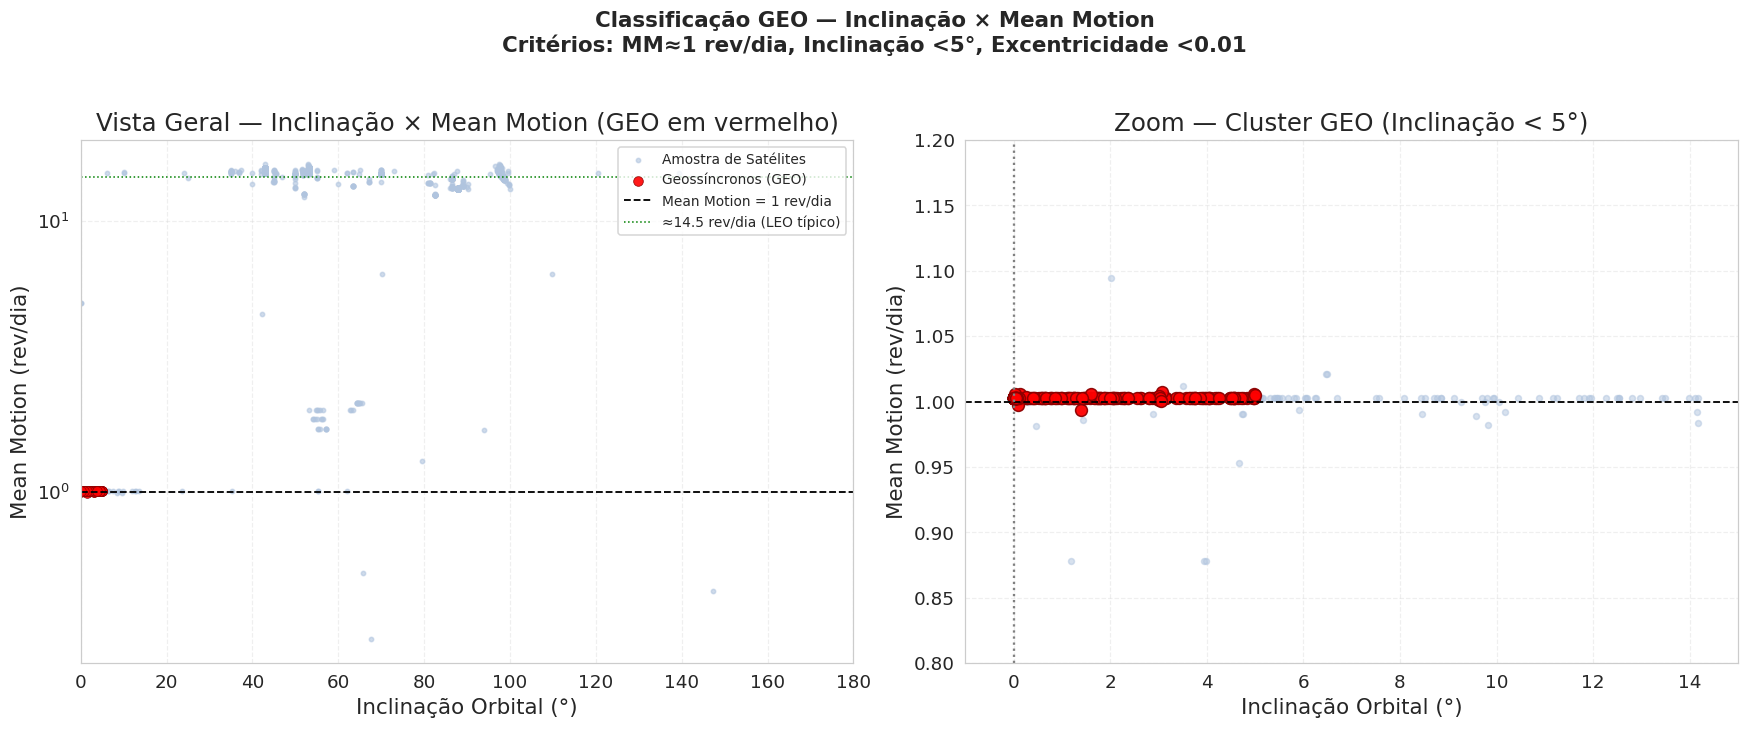

Figura salva em: /content/figuras_artigo/geo_classificacao_dupla.png
Arquivo CSV salvo em: /content/figuras_artigo/satellites_geo_classificados.csv
Classificação GEO concluída.


In [ ]:
# MÓDULO 4 — CLASSIFICAÇÃO DE SATÉLITES GEOSSÍNCRONOS (GEO)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import gc

plt.rcParams.update({
    'figure.dpi': 110,
    'axes.grid': True,
    'grid.alpha': 0.3,
    'grid.linestyle': '--',
    'legend.frameon': True
})

print("Iniciando classificação GEO.")

# Verificação de colunas necessárias
colunas_necessarias = ['MEAN_MOTION', 'INCLINATION', 'ECCENTRICITY']

for col in colunas_necessarias:
    if col not in df.columns:
        raise ValueError(f"Erro: A coluna obrigatória '{col}' não está presente no dataframe.")

print("Colunas necessárias encontradas.")

# Função de classificação GEO
def is_geo(row):
    mm = row['MEAN_MOTION']
    inc = row['INCLINATION']
    ecc = row['ECCENTRICITY']
    alt = row['ALTITUDE_KM']

    if pd.isna(mm) or pd.isna(inc) or pd.isna(ecc) or pd.isna(alt):
        return False

    if not (0.99 <= mm <= 1.01):
        return False

    if abs(inc) > 5:
        return False

    if ecc >= 0.01:
        return False

    if abs(alt - 35786) > 300:
        return False

    return True

df['TIPO_ORBITA'] = df.apply(lambda row: 'Geossíncrono (GEO)' if is_geo(row) else 'Não-Geossíncrono', axis=1)

n_total = len(df)
n_geo = df['TIPO_ORBITA'].value_counts().get('Geossíncrono (GEO)', 0)

print(f"Total de satélites analisados: {n_total}")
print(f"Satélites classificados como GEO: {n_geo}")
print(f"Satélites não-GEO: {n_total - n_geo}")

df_geo = df[df['TIPO_ORBITA'] == 'Geossíncrono (GEO)']

# Gráficos: visão geral e zoom no cluster GEO
plt.close('all')
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 7))

# Subplot 1 — visão geral
amostra_size = min(2500, int(n_total * 0.2))
df_amostra = df.sample(n=amostra_size, random_state=42) if n_total > amostra_size else df

ax1.scatter(
    df_amostra['INCLINATION'],
    df_amostra['MEAN_MOTION'],
    s=8,
    alpha=0.6,
    color='lightsteelblue',
    label='Amostra de Satélites'
)

if n_geo > 0:
    ax1.scatter(
        df_geo['INCLINATION'],
        df_geo['MEAN_MOTION'],
        s=40,
        alpha=0.9,
        color='red',
        edgecolor='darkred',
        linewidth=0.5,
        label='Geossíncronos (GEO)'
    )

ax1.axhline(1.0, color='black', linestyle='--', linewidth=1.2, label='Mean Motion = 1 rev/dia')
ax1.axhline(14.5, color='green', linestyle=':', linewidth=1, label='≈14.5 rev/dia (LEO típico)')
ax1.axvline(0, color='gray', linestyle=':', linewidth=1)

ax1.set_yscale('log')
ax1.set_xlim(0, 180)
ax1.set_xlabel('Inclinação Orbital (°)')
ax1.set_ylabel('Mean Motion (rev/dia)')
ax1.set_title('Vista Geral — Inclinação × Mean Motion (GEO em vermelho)')
ax1.legend(fontsize=9, loc='upper right')

# Subplot 2 — zoom no cluster GEO
df_zoom = df[
    (df['INCLINATION'] < 15) &
    (df['MEAN_MOTION'].between(0.8, 1.2))
]

ax2.scatter(
    df_zoom['INCLINATION'],
    df_zoom['MEAN_MOTION'],
    s=15,
    alpha=0.5,
    color='lightsteelblue',
    label='Satélites Próximos'
)

if n_geo > 0:
    ax2.scatter(
        df_geo['INCLINATION'],
        df_geo['MEAN_MOTION'],
        s=60,
        alpha=0.95,
        color='red',
        edgecolor='darkred',
        linewidth=1,
        label='Geossíncronos (GEO)'
    )

ax2.axhline(1.0, color='black', linestyle='--', linewidth=1.2)
ax2.axvline(0, color='gray', linestyle=':')

ax2.set_xlim(-1, 15)
ax2.set_ylim(0.8, 1.2)
ax2.set_xlabel('Inclinação Orbital (°)')
ax2.set_ylabel('Mean Motion (rev/dia)')
ax2.set_title('Zoom — Cluster GEO (Inclinação < 5°)')

# Título geral
fig.suptitle(
    'Classificação GEO — Inclinação × Mean Motion\n'
    'Critérios: MM≈1 rev/dia, Inclinação <5°, Excentricidade <0.01',
    fontsize=14,
    fontweight='bold',
    y=0.97
)

plt.tight_layout(rect=[0, 0.03, 1, 0.94])

# Salvamento
fig_path = f"{output_dir}/geo_classificacao_dupla.png"
plt.savefig(fig_path, dpi=150, bbox_inches='tight')

plt.show()

print(f"Figura salva em: {fig_path}")

# Exportação dos dados GEO
df_geo.to_csv(f"{output_dir}/satellites_geo_classificados.csv", index=False)
print(f"Arquivo CSV salvo em: {output_dir}/satellites_geo_classificados.csv")

gc.collect()

print("Classificação GEO concluída.")



K-Means (k=4) – Percentuais reais:

Cluster C0: 48.63% (6230 satélites) — Regime predominante: LEO
Cluster C1: 5.90% (756 satélites) — Regime predominante: GEO
Cluster C2: 45.15% (5784 satélites) — Regime predominante: LEO
Cluster C3: 0.31% (40 satélites) — Regime predominante: MEO

Linha LaTeX:

Clusters (K-Means) & C0: 48.63\% ; C1: 5.90\% ; C2: 45.15\% ; C3: 0.31\% \\


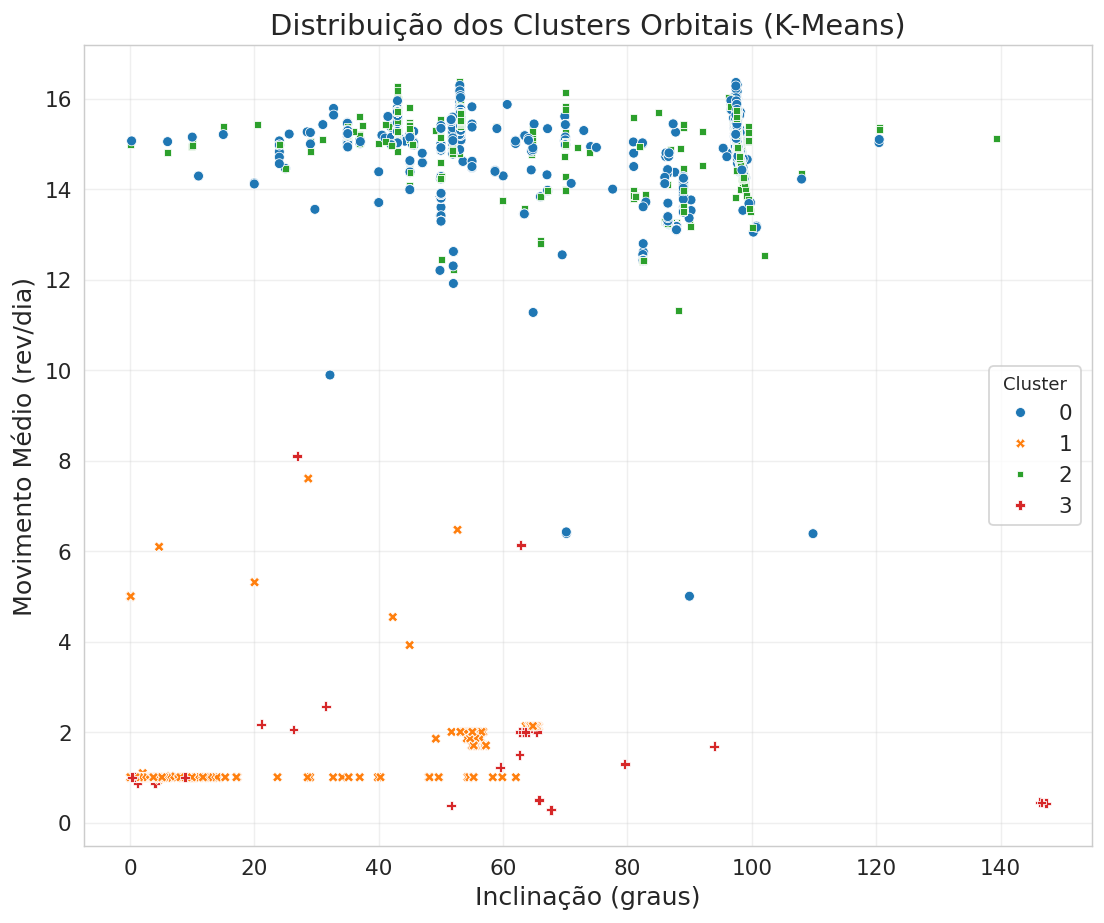

In [ ]:
# MÓDULO 5 — Agrupamento Orbital por K-Means e Resumo dos Clusters

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np

# Carrega o arquivo principal
csv_path = "/content/drive/MyDrive/Aeroespacial/active_satellites.csv"
df = pd.read_csv(csv_path)

# Classificação simples por regime orbital
def regime_orbital(mean_motion):
    if pd.isna(mean_motion):
        return 'HEO'
    if 0.99 <= mean_motion <= 1.01:
        return 'GEO'
    elif 2 <= mean_motion < 11:
        return 'MEO'
    elif mean_motion >= 11:
        return 'LEO'
    return 'HEO'

df["_REGIME"] = df["MEAN_MOTION"].apply(regime_orbital)

# Seleção das features do clustering
feats = ["INCLINATION", "MEAN_MOTION", "ECCENTRICITY", "RA_OF_ASC_NODE"]
df_valid = df.dropna(subset=feats).copy()
idx_valid = df_valid.index

# Padronização
scaler = StandardScaler()
X = scaler.fit_transform(df_valid[feats])

# K-Means
km = KMeans(n_clusters=4, random_state=42, n_init=10)
labels = km.fit_predict(X)

df["cluster_km"] = np.nan
df.loc[idx_valid, "cluster_km"] = labels
df["cluster_km"] = df["cluster_km"].astype("Int64")

# Percentuais reais
contagens = df["cluster_km"].value_counts().sort_index()
total = contagens.sum()

print("\nK-Means (k=4) – Percentuais reais:\n")

# Regime predominante por cluster
regime_por_cluster = (
    df.dropna(subset=["cluster_km"])
      .groupby("cluster_km")["_REGIME"]
      .agg(lambda s: s.mode().iat[0])
      .to_dict()
)

resumo_latex = []

for c in contagens.index:
    pct = 100 * contagens[c] / total
    regime = regime_por_cluster[c]
    print(f"Cluster C{c}: {pct:.2f}% ({contagens[c]} satélites) — Regime predominante: {regime}")
    resumo_latex.append(f"C{c}: {pct:.2f}\\%")

# Linha LaTeX
linha_latex = "Clusters (K-Means) & " + " ; ".join(resumo_latex) + " \\\\"
print("\nLinha LaTeX:\n")
print(linha_latex)

# Gráfico
plt.figure(figsize=(10, 8))
sns.scatterplot(
    data=df_valid,
    x="INCLINATION",
    y="MEAN_MOTION",
    hue=labels,
    palette="tab10",
    style=labels,
    s=30
)

plt.title("Distribuição dos Clusters Orbitais (K-Means)")
plt.xlabel("Inclinação (graus)")
plt.ylabel("Movimento Médio (rev/dia)")
plt.grid(True, alpha=0.3)
plt.legend(title="Cluster")
plt.show()


Iniciando módulo 6 — Visualização de Risco Orbital.


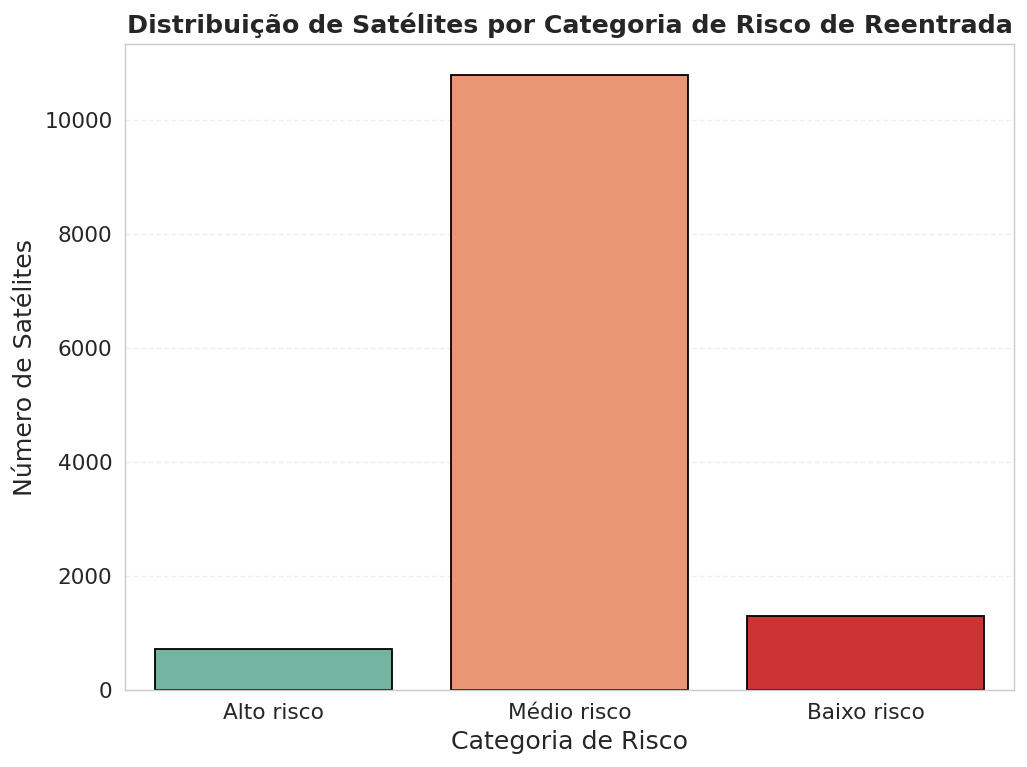

Histograma concluído e salvo.


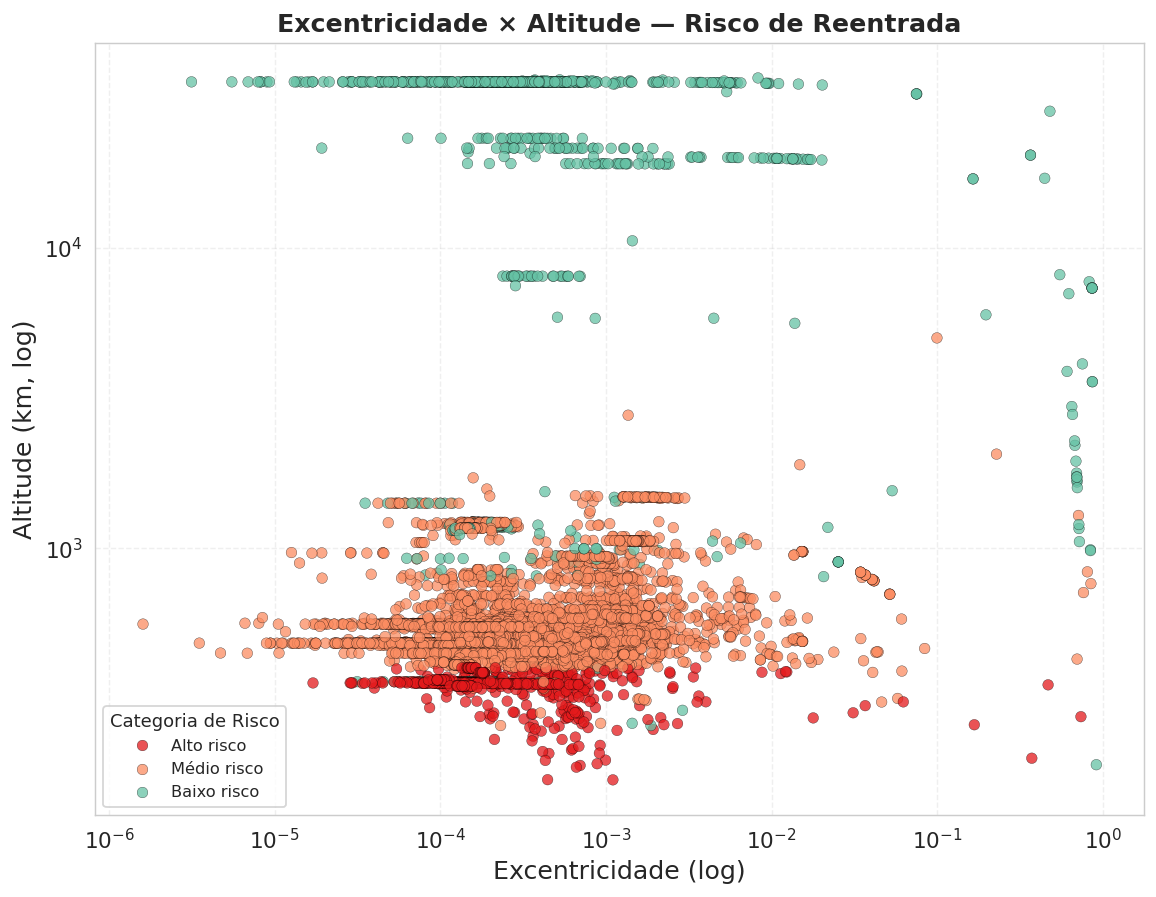

Scatter ECC × Altitude concluído e salvo em output_dir.
Exportação concluída: risco_orbital_tabela.csv
Módulo 6 finalizado com sucesso.


In [ ]:
# MÓDULO 6 — VISUALIZAÇÃO DE RISCO ORBITAL

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")
plt.rcParams['figure.dpi'] = 130

print("Iniciando módulo 6 — Visualização de Risco Orbital.")

# Verificação de colunas necessárias
necessarias = ['ECCENTRICITY', 'BSTAR', 'MEAN_MOTION', 'REV_AT_EPOCH']

for col in necessarias:
    if col not in df.columns:
        raise ValueError(f"Coluna obrigatória ausente: {col}")

# Calcular altitude se não existir
if 'ALTITUDE_KM' not in df.columns:
    print("ALTITUDE_KM não encontrada. Calculando via Kepler...")
    MU = 3.986004418e14
    R_E = 6378137.0
    SEG_POR_DIA = 86400

    def _semi_eixo(n_rev_dia):
        if pd.isna(n_rev_dia) or n_rev_dia <= 0:
            return np.nan
        n_rad_s = n_rev_dia * 2*np.pi/SEG_POR_DIA
        return (MU/(n_rad_s**2))**(1/3)

    def _altitude_perigeu(a_m, e):
        if pd.isna(a_m) or pd.isna(e):
            return np.nan
        return (a_m*(1 - e) - R_E)/1000.0

    df['SEMI_EIXO_MAIOR_M'] = df['MEAN_MOTION'].apply(_semi_eixo)
    df['ALTITUDE_KM'] = df.apply(
        lambda r: _altitude_perigeu(r['SEMI_EIXO_MAIOR_M'], r['ECCENTRICITY']),
        axis=1
    )

df['ALTITUDE_PERIGEU_KM'] = df['SEMI_EIXO_MAIOR_M'] * (1 - df['ECCENTRICITY']) / 1000 - 6378.137

# Garantir ABS_BSTAR
if 'ABS_BSTAR' not in df.columns:
    df['ABS_BSTAR'] = df['BSTAR'].abs()

# Classificação de risco
def classificar_risco_reentrada(row):
    hp = row['ALTITUDE_PERIGEU_KM']
    b = abs(row['BSTAR'])

    if pd.isna(hp) or pd.isna(b):
        return 'Desconhecido'

    if hp < 120:
        return 'Reentrada iminente'

    if (hp < 400) and (b > 5e-4):
        return 'Alto risco'

    elif (400 <= hp < 800) or (b > 1e-4):
        return 'Médio risco'

    else:
        return 'Baixo risco'

df['RISCO_REENTRADA'] = df.apply(classificar_risco_reentrada, axis=1)

ordem_risco = [
    'Reentrada iminente',
    'Alto risco',
    'Médio risco',
    'Baixo risco',
    'Desconhecido'
]

# Histograma
plt.figure(figsize=(8,6))
sns.countplot(
    data=df,
    x='RISCO_REENTRADA',
    order=[c for c in ordem_risco if c in df['RISCO_REENTRADA'].unique()],
    palette=['#66c2a5', '#fc8d62', '#e41a1c', 'gray'],
    edgecolor='black'
)

plt.title('Distribuição de Satélites por Categoria de Risco de Reentrada',
          fontsize=14, weight='bold')
plt.xlabel('Categoria de Risco')
plt.ylabel('Número de Satélites')
plt.grid(axis='y', alpha=0.3, linestyle='--')
plt.tight_layout()

plt.savefig(f"{output_dir}/hist_risco_orbital.png", dpi=400, bbox_inches='tight')
plt.show()

print("Histograma concluído e salvo.")

# Scatter ECC vs ALTITUDE
df_plot = df.copy()
df_plot['ECCENTRICITY'] = pd.to_numeric(df_plot['ECCENTRICITY'], errors='coerce')
df_plot['ALTITUDE_KM'] = pd.to_numeric(df_plot['ALTITUDE_KM'], errors='coerce')

df_plot = df_plot[(df_plot['ECCENTRICITY'] > 0) & (df_plot['ALTITUDE_KM'] > 0)]

palette_risco = {
    'Reentrada iminente': '#800000',
    'Alto risco': '#e41a1c',
    'Médio risco': '#fc8d62',
    'Baixo risco': '#66c2a5',
    'Desconhecido': 'gray'
}

hue_levels = [c for c in ordem_risco if c in df_plot['RISCO_REENTRADA'].unique()]

plt.figure(figsize=(9,7))
sns.scatterplot(
    data=df_plot,
    x='ECCENTRICITY',
    y='ALTITUDE_KM',
    hue='RISCO_REENTRADA',
    hue_order=hue_levels,
    palette={k:v for k,v in palette_risco.items() if k in hue_levels},
    s=35,
    alpha=0.75,
    edgecolor='black',
    linewidth=0.2
)

plt.xscale('log')
plt.yscale('log')
plt.xlabel('Excentricidade (log)')
plt.ylabel('Altitude (km, log)')
plt.title('Excentricidade × Altitude — Risco de Reentrada',
          fontsize=14, weight='bold')
plt.legend(title='Categoria de Risco', fontsize=9, title_fontsize=10)
plt.grid(alpha=0.3, linestyle='--')

plt.tight_layout()
plt.savefig(f"{output_dir}/scatter_risco_excentricidade_altitude.png",
            dpi=400, bbox_inches='tight')
plt.show()

print("Scatter ECC × Altitude concluído e salvo em output_dir.")

# Exportação final
df[['OBJECT_NAME','ECCENTRICITY','ALTITUDE_KM','ALTITUDE_PERIGEU_KM','ABS_BSTAR','RISCO_REENTRADA']].to_csv(
    f"{output_dir}/risco_orbital_tabela.csv", index=False
)

print("Exportação concluída: risco_orbital_tabela.csv")
print("Módulo 6 finalizado com sucesso.")


=== DETECÇÃO DE ANOMALIAS ORBITAIS (IsolationForest) ===
Cenário aplicado ao BSTAR: atual

Colunas disponíveis em df:
['OBJECT_NAME', 'OBJECT_ID', 'EPOCH', 'MEAN_MOTION', 'ECCENTRICITY', 'INCLINATION', 'RA_OF_ASC_NODE', 'ARG_OF_PERICENTER', 'MEAN_ANOMALY', 'EPHEMERIS_TYPE', 'CLASSIFICATION_TYPE', 'NORAD_CAT_ID', 'ELEMENT_SET_NO', 'REV_AT_EPOCH', 'BSTAR', 'MEAN_MOTION_DOT', 'MEAN_MOTION_DDOT', 'SEMI_EIXO_MAIOR_M', 'ALTITUDE_KM', 'ABS_BSTAR', 'PAIS', 'Faixa_Inclinacao', 'REGIAO', 'ECC_CLASS', 'CLASSE_BSTAR', 'TIPO_SATELITE', 'CONSTELACAO', 'FAIXA_ORBITA', 'Regiao', 'TIPO_ORBITA', 'ALTITUDE_PERIGEU_KM', 'RISCO_REENTRADA']

Colunas garantidas para análise:
['BSTAR', 'ECCENTRICITY', 'REV_AT_EPOCH', 'ALTITUDE_KM', 'MEAN_MOTION_DOT']

Após limpeza: 12810 registros.
Features usadas: ['ABS_BSTAR', 'ECCENTRICITY', 'MEAN_MOTION_DOT', 'REV_AT_EPOCH']
Contaminação usada: 0.050

Anomalias detectadas: 641 (5.00%)


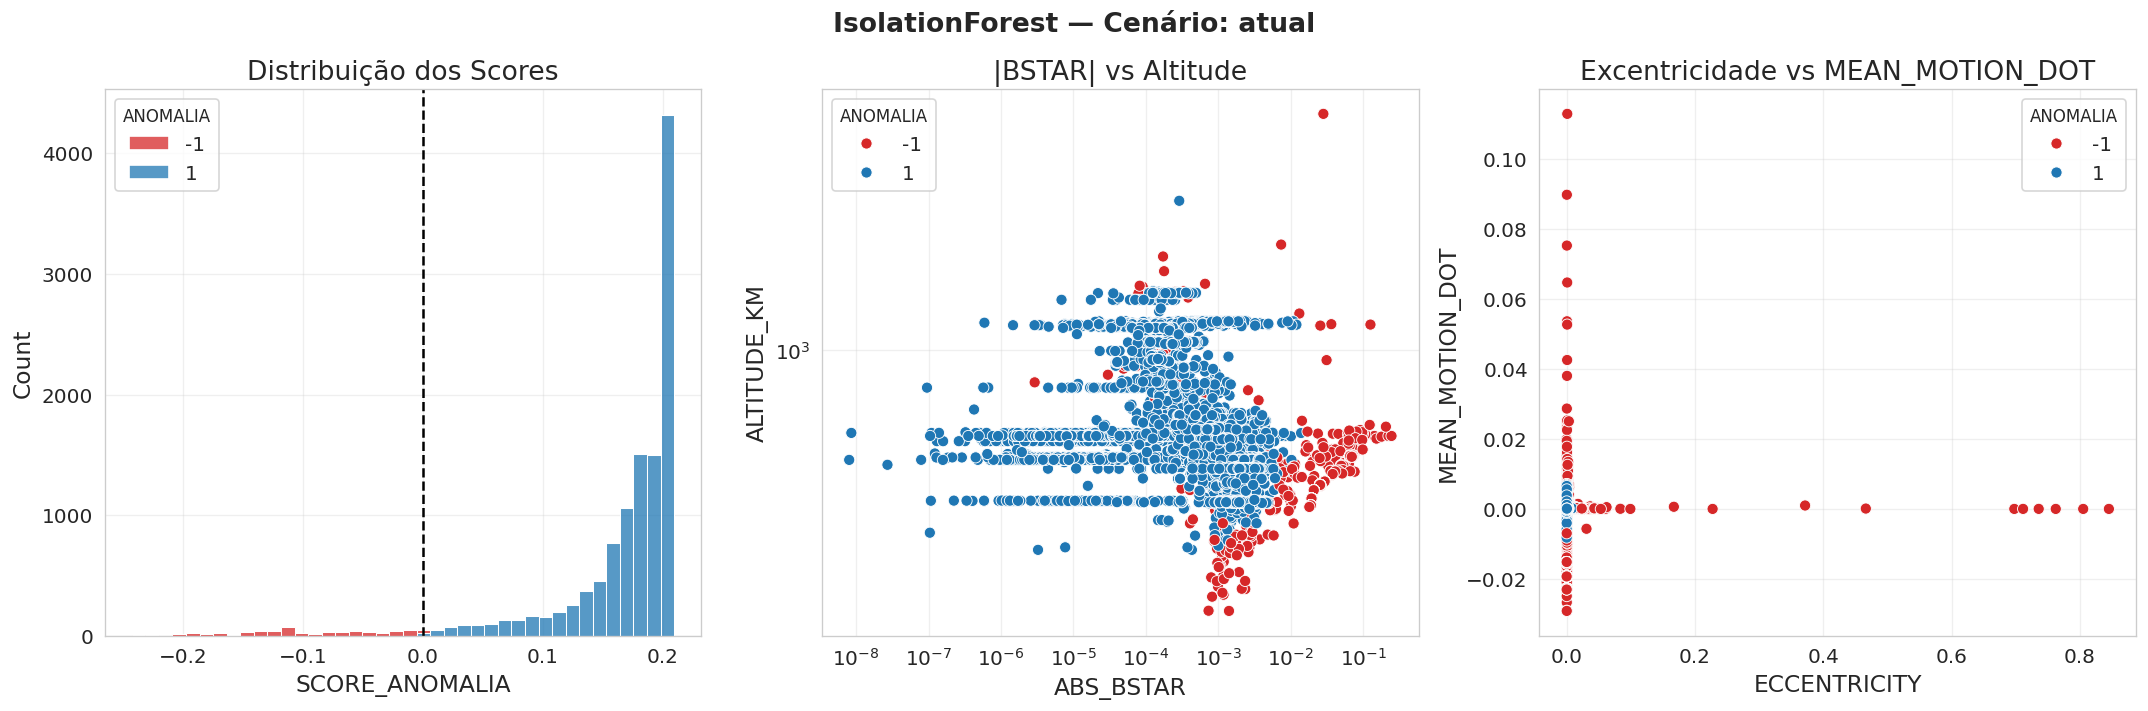


Figura salva em: anomalias_orbitais_atual.png
CSV salvo em:    anomalias_orbitais_atual.csv

=== RESUMO GERAL ===
Total analisado: 12810
Anomalias: 641 (5.00%)


In [ ]:
# MÓDULO 7 — DETECÇÃO DE ANOMALIAS ORBITAIS (IsolationForest)

from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings, os

warnings.filterwarnings('ignore')
sns.set_style("whitegrid")
plt.rcParams['figure.dpi'] = 120
plt.ioff()

# Parâmetro do cenário
CENARIO = 'atual'

def ajustar_bstar_cenario(df_in, cenario='atual'):
    df_ = df_in.copy()

    if cenario == 'tempestade_geomagnetica':
        df_['BSTAR'] *= 1.40

    elif cenario == 'aquecimento':
        df_.loc[(df_['ALTITUDE_KM'] > 500) & (df_['ALTITUDE_KM'] <= 600), 'BSTAR'] *= 0.80
        df_.loc[df_['ALTITUDE_KM'] > 600, 'BSTAR'] *= 0.60

    elif cenario == 'secular_2100':
        df_.loc[(df_['ALTITUDE_KM'] > 500) & (df_['ALTITUDE_KM'] <= 600), 'BSTAR'] *= 0.50
        df_.loc[df_['ALTITUDE_KM'] > 600, 'BSTAR'] *= 0.30

    return df_

print("=== DETECÇÃO DE ANOMALIAS ORBITAIS (IsolationForest) ===")
print(f"Cenário aplicado ao BSTAR: {CENARIO}")

# Verificações de colunas
print("\nColunas disponíveis em df:")
print(list(df.columns))

if 'ALTITUDE_KM' not in df.columns:
    raise ValueError("A coluna 'ALTITUDE_KM' é obrigatória.")

if 'ECCENTRICITY' not in df.columns:
    candidatos_ecc = [c for c in df.columns if 'ECC' in c.upper()]
    if candidatos_ecc:
        col_ecc = candidatos_ecc[0]
        print(f"[AVISO] Usando '{col_ecc}' como ECCENTRICITY.")
        df['ECCENTRICITY'] = df[col_ecc]
    else:
        print("[AVISO] Criando ECCENTRICITY = 0.0.")
        df['ECCENTRICITY'] = 0.0

if 'BSTAR' not in df.columns:
    candidatos_bstar = [c for c in df.columns if 'BSTAR' in c.upper()]
    if candidatos_bstar:
        col_bstar = candidatos_bstar[0]
        print(f"[AVISO] Usando '{col_bstar}' como BSTAR.")
        df['BSTAR'] = df[col_bstar]
    else:
        print("[AVISO] Criando BSTAR = 0.0.")
        df['BSTAR'] = 0.0

if 'REV_AT_EPOCH' not in df.columns:
    print("[AVISO] Criando REV_AT_EPOCH = 0.0.")
    df['REV_AT_EPOCH'] = 0.0

if 'MEAN_MOTION_DOT' not in df.columns:
    print("[AVISO] Criando MEAN_MOTION_DOT = 0.0.")
    df['MEAN_MOTION_DOT'] = 0.0

cols_minimas = ['BSTAR', 'ECCENTRICITY', 'REV_AT_EPOCH', 'ALTITUDE_KM', 'MEAN_MOTION_DOT']

print("\nColunas garantidas para análise:")
print(cols_minimas)

# Aplicar cenário
df_cen = ajustar_bstar_cenario(df, CENARIO).copy()
df_cen['ABS_BSTAR'] = df_cen['BSTAR'].abs()

# Limpeza
features_anomalia = ['ABS_BSTAR', 'ECCENTRICITY', 'MEAN_MOTION_DOT', 'REV_AT_EPOCH']

df_limpo = (
    df_cen
    .dropna(subset=features_anomalia + ['ALTITUDE_KM'])
    .copy()
)
df_limpo = df_limpo[df_limpo['ALTITUDE_KM'] > 0]

print(f"\nApós limpeza: {len(df_limpo)} registros.")
print("Features usadas:", features_anomalia)

# Escalonamento + IsolationForest
X = df_limpo[features_anomalia].astype(float)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

contamination_level = min(0.1, max(0.05, 500 / max(len(df_limpo), 1)))
print(f"Contaminação usada: {contamination_level:.3f}")

iso_forest = IsolationForest(
    contamination=contamination_level,
    random_state=42,
    n_estimators=200,
    n_jobs=-1
)

df_limpo['ANOMALIA'] = iso_forest.fit_predict(X_scaled)
df_limpo['SCORE_ANOMALIA'] = iso_forest.decision_function(X_scaled)

# Resultados
num_anom = (df_limpo['ANOMALIA'] == -1).sum()
pct_anom = num_anom / len(df_limpo) * 100

print(f"\nAnomalias detectadas: {num_anom} ({pct_anom:.2f}%)")

df_anom = df_limpo[df_limpo['ANOMALIA'] == -1].sort_values('SCORE_ANOMALIA')

# Preparação dos dados para gráfico
df_plot = df_limpo[
    (df_limpo['ABS_BSTAR'] > 0) &
    (df_limpo['ALTITUDE_KM'] > 0)
].copy()

# Gráficos
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
plt.subplots_adjust(wspace=0.35)

palette = {-1: '#d62728', 1: '#1f77b4'}

sns.histplot(
    df_plot,
    x='SCORE_ANOMALIA',
    hue='ANOMALIA',
    bins=40,
    multiple='stack',
    palette=palette,
    ax=axes[0]
)
axes[0].axvline(0, color='black', linestyle='--')
axes[0].set_title("Distribuição dos Scores")

sns.scatterplot(
    data=df_plot,
    x='ABS_BSTAR',
    y='ALTITUDE_KM',
    hue='ANOMALIA',
    palette=palette,
    ax=axes[1],
    s=45
)
axes[1].set_xscale('log')
axes[1].set_yscale('log')
axes[1].set_title("|BSTAR| vs Altitude")

sns.scatterplot(
    data=df_plot,
    x='ECCENTRICITY',
    y='MEAN_MOTION_DOT',
    hue='ANOMALIA',
    palette=palette,
    ax=axes[2],
    s=45
)
axes[2].set_title("Excentricidade vs MEAN_MOTION_DOT")

plt.suptitle(
    f"IsolationForest — Cenário: {CENARIO}",
    fontsize=16,
    weight='bold'
)
plt.tight_layout()
plt.show()

# Salvamento
suf = CENARIO.replace(" ", "_")
fig_path = f"anomalias_orbitais_{suf}.png"
csv_path = f"anomalias_orbitais_{suf}.csv"

df_limpo.to_csv(csv_path, index=False)
plt.savefig(fig_path, dpi=150, bbox_inches='tight')

print(f"\nFigura salva em: {fig_path}")
print(f"CSV salvo em:    {csv_path}")

# Resumo final
print("\n=== RESUMO GERAL ===")
print(f"Total analisado: {len(df_limpo)}")
print(f"Anomalias: {num_anom} ({pct_anom:.2f}%)")


=== PIPELINE UNIFICADO — RISCO ORBITAL ===

[Modelo A — Ruído] Acurácia=0.898 | F1=0.877


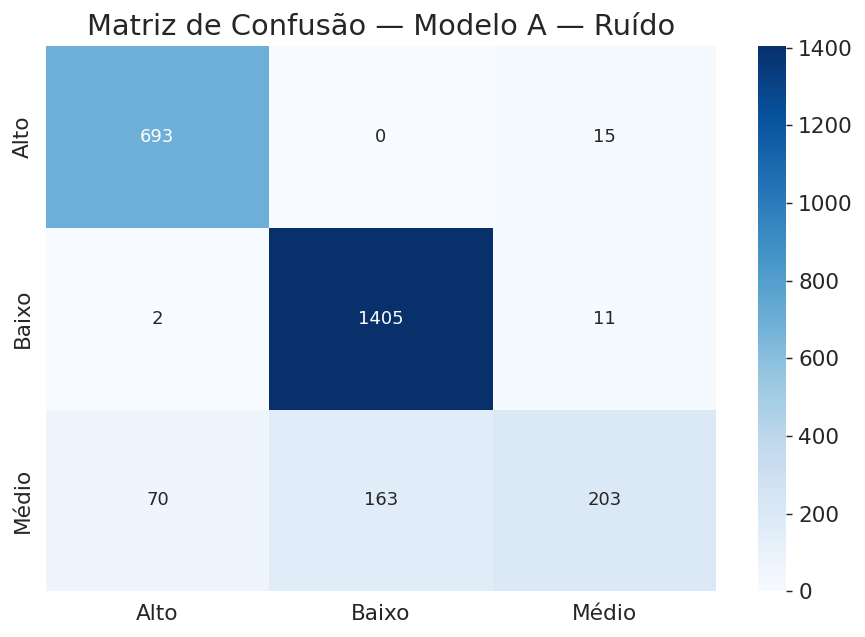

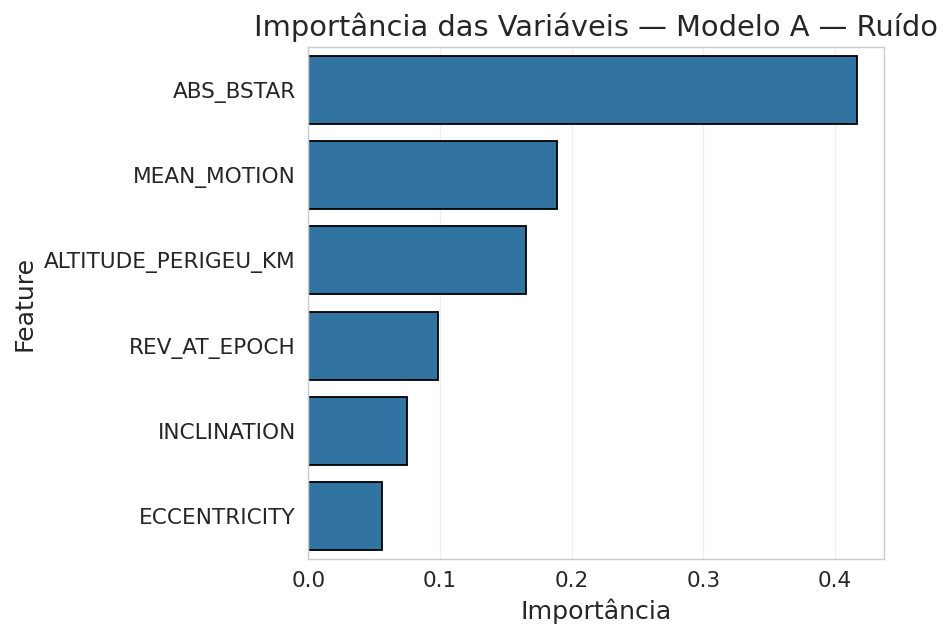


Linha LaTeX para tabela:
Importância das Variáveis (RF) & ABS_BSTAR = 0.417 ; ALTITUDE_PERIGEU_KM = 0.165 ; ECCENTRICITY = 0.056 \\

[Modelo B — Aquecimento Global] Acurácia=0.901 | F1=0.881


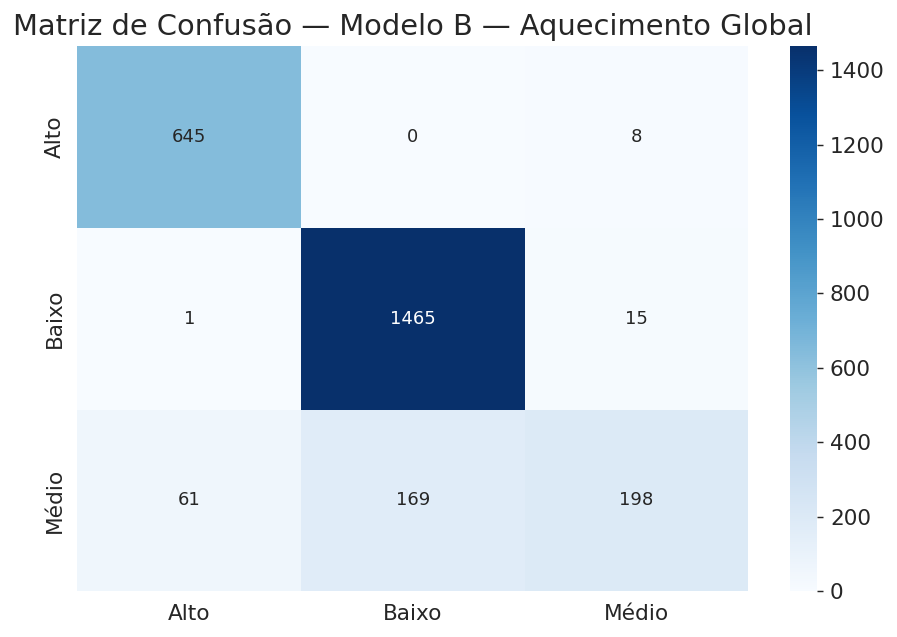

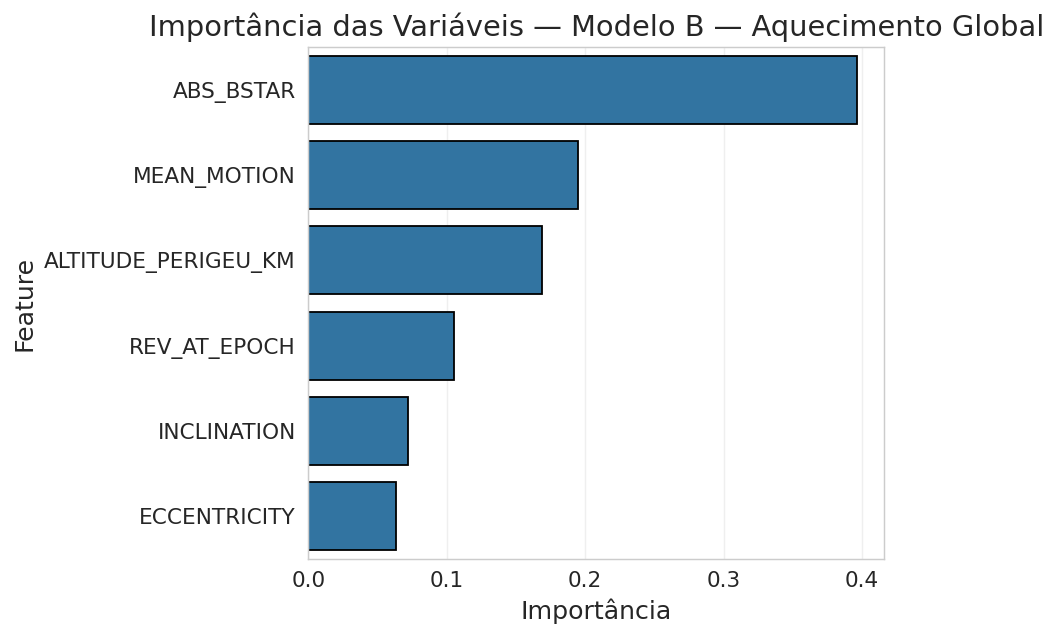


Linha LaTeX para tabela:
Importância das Variáveis (RF) & ABS_BSTAR = 0.396 ; ALTITUDE_PERIGEU_KM = 0.169 ; ECCENTRICITY = 0.063 \\

[Modelo C — Tempestade Geomagnética] Acurácia=0.898 | F1=0.884


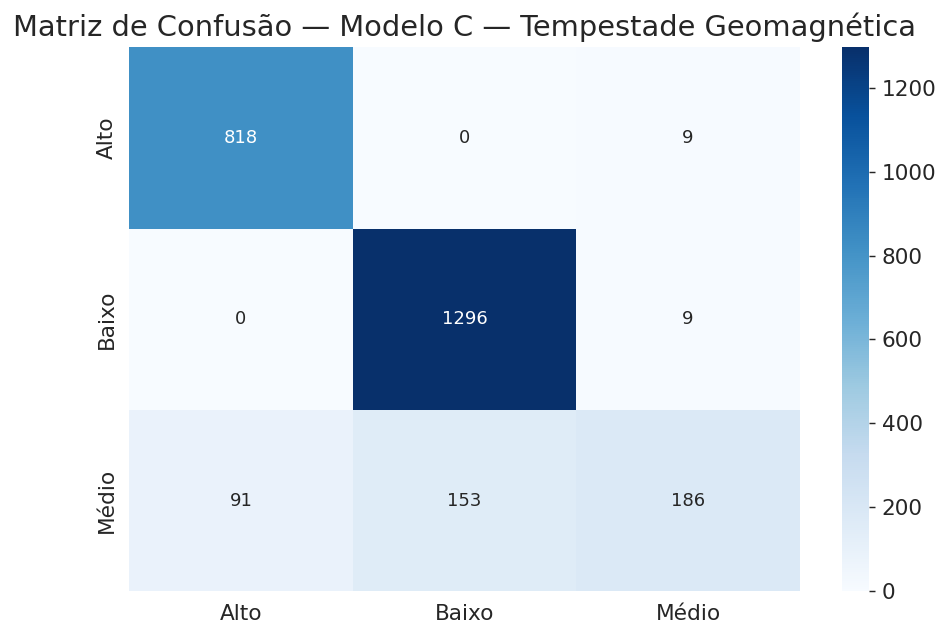

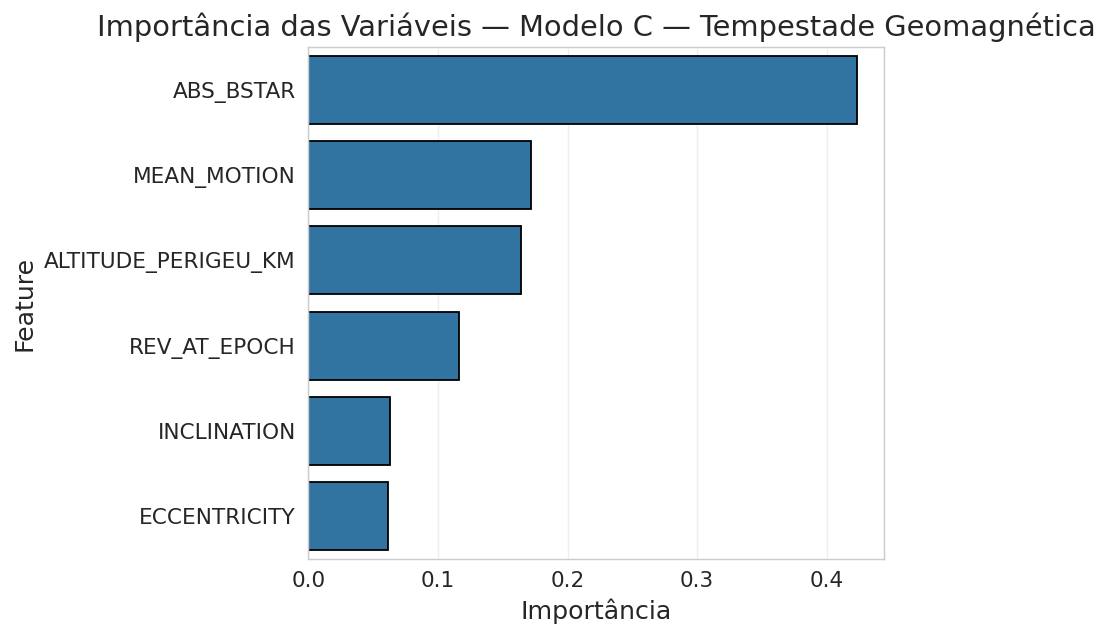


Linha LaTeX para tabela:
Importância das Variáveis (RF) & ABS_BSTAR = 0.423 ; ALTITUDE_PERIGEU_KM = 0.164 ; ECCENTRICITY = 0.062 \\

Resumo comparativo:
           Cenário  Acurácia  F1 Médio
0        Ruído (A)     0.898     0.877
1  Aquecimento (B)     0.901     0.881
2   Tempestade (C)     0.898     0.884


In [ ]:

# MÓDULO 8 — Pipeline Unificado de Classificação de Risco Orbital

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings, os

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

warnings.filterwarnings('ignore')
sns.set_style("whitegrid")
plt.rcParams['figure.dpi'] = 130

SEED = 42
np.random.seed(SEED)

CAMINHO_CSV = '/content/drive/MyDrive/Aeroespacial/active_satellites.csv'
PASTA_SAIDA = '/content'
os.makedirs(PASTA_SAIDA, exist_ok=True)

print("=== PIPELINE UNIFICADO — RISCO ORBITAL ===")

df = pd.read_csv(CAMINHO_CSV)

MU = 3.986004418e14
R_TERRA = 6378137.0
SEG_POR_DIA = 86400

df['PERIOD'] = 1440.0 / df['MEAN_MOTION']

df['MEAN_MOTION_RAD_S'] = np.where(
    (df['MEAN_MOTION'] > 0) & (df['MEAN_MOTION'] < 200),
    df['MEAN_MOTION'] * 2 * np.pi / SEG_POR_DIA,
    np.nan
)

n2 = df['MEAN_MOTION_RAD_S'] ** 2

df['SEMI_AXIS_M'] = np.where(
    df['MEAN_MOTION_RAD_S'].notna(),
    np.power(MU / n2, 1/3),
    np.nan
)

df['ALTITUDE_KM'] = np.where(
    df['SEMI_AXIS_M'].notna(),
    (df['SEMI_AXIS_M'] - R_TERRA) / 1000.0,
    np.nan
)

df['ALTITUDE_PERIGEU_KM'] = (
    (df['SEMI_AXIS_M'] * (1 - df['ECCENTRICITY'])) / 1000.0
) - 6378.137

features_base = [
    'INCLINATION',
    'MEAN_MOTION',
    'ECCENTRICITY',
    'BSTAR',
    'REV_AT_EPOCH',
    'ALTITUDE_KM',
    'ALTITUDE_PERIGEU_KM'
]

df_limpo = df.dropna(subset=features_base)
df_limpo = df_limpo[
    (df_limpo['ALTITUDE_KM'] > 0) &
    (df_limpo['ALTITUDE_KM'] < 100000)
].copy()

def ajustar_bstar_clima(df_in, clima='atual'):
    df_ = df_in.copy()

    if clima == 'aquecimento':
        df_.loc[(df_['ALTITUDE_KM'] > 500) & (df_['ALTITUDE_KM'] <= 600), 'BSTAR'] *= 0.80
        df_.loc[df_['ALTITUDE_KM'] > 600, 'BSTAR'] *= 0.60

    elif clima == 'tempestade_geomagnetica':
        df_['BSTAR'] *= 1.40

    elif clima == 'secular_2100':
        df_.loc[df_['ALTITUDE_KM'] > 600, 'BSTAR'] *= 0.30

    return df_

def rotulo_risco(row, prob_ruido=0.10):
    alt = row['ALTITUDE_KM']
    b = abs(row['BSTAR'])
    e = row['ECCENTRICITY']
    rev = row['REV_AT_EPOCH']

    if alt < 1000 and (b > 0.001 or e > 0.05 or rev < 100):
        risco = 'Alto'
    elif (1000 <= alt < 20000) or (0.01 < e <= 0.05):
        risco = 'Médio'
    else:
        risco = 'Baixo'

    if np.random.rand() < prob_ruido:
        ordem = ['Baixo', 'Médio', 'Alto']
        i = ordem.index(risco)
        if i == 0:
            return 'Médio'
        if i == 1:
            return np.random.choice(['Baixo', 'Alto'])
        return 'Médio'

    return risco

def treinar_avaliar_rf(df_in, nome_execucao, prefixo):
    feats = [
        'INCLINATION',
        'MEAN_MOTION',
        'ECCENTRICITY',
        'ABS_BSTAR',
        'REV_AT_EPOCH',
        'ALTITUDE_PERIGEU_KM'
    ]
    alvo = 'RISCO'

    X = df_in[feats]
    y = df_in[alvo]

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, stratify=y, random_state=SEED
    )

    scaler = StandardScaler()
    X_train_s = scaler.fit_transform(X_train)
    X_test_s = scaler.transform(X_test)

    le = LabelEncoder()
    y_train_enc = le.fit_transform(y_train)
    y_test_enc = le.transform(y_test)

    modelo = RandomForestClassifier(
        n_estimators=150,
        max_depth=12,
        random_state=SEED,
        class_weight='balanced'
    )

    cv_f1 = cross_val_score(modelo, X_train_s, y_train_enc, cv=5, scoring='f1_weighted')

    modelo.fit(X_train_s, y_train_enc)
    y_pred = le.inverse_transform(modelo.predict(X_test_s))

    acc = accuracy_score(y_test, y_pred)

    print(f"\n[{nome_execucao}] Acurácia={acc:.3f} | F1={cv_f1.mean():.3f}")

    cm = confusion_matrix(y_test, y_pred, labels=le.classes_)

    plt.figure(figsize=(7, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=le.classes_, yticklabels=le.classes_)
    plt.title(f"Matriz de Confusão — {nome_execucao}")
    plt.tight_layout()
    plt.savefig(f"{PASTA_SAIDA}/{prefixo}_confusao.png", dpi=200)
    plt.show()

    fi_df = pd.DataFrame({
        'Feature': feats,
        'Importância': modelo.feature_importances_
    })

    plt.figure(figsize=(7, 5))
    sns.barplot(
        data=fi_df.sort_values('Importância', ascending=False),
        x='Importância', y='Feature',
        color='#1f77b4', edgecolor='black'
    )
    plt.title(f"Importância das Variáveis — {nome_execucao}")
    plt.tight_layout()
    plt.savefig(f"{PASTA_SAIDA}/{prefixo}_importancias.png", dpi=200)
    plt.show()

    ordem = ["ABS_BSTAR", "ALTITUDE_PERIGEU_KM", "ECCENTRICITY"]
    partes = []
    for feat in ordem:
        importancia = float(fi_df.loc[fi_df["Feature"] == feat, "Importância"])
        partes.append(f"{feat} = {importancia:.3f}")

    linha_latex = "Importância das Variáveis (RF) & " + " ; ".join(partes) + " \\\\"

    print("\nLinha LaTeX para tabela:")
    print(linha_latex)

    return {
        'acc': acc,
        'f1': cv_f1.mean(),
        'fi': fi_df,
        'latex': linha_latex
    }

df_ruido = df_limpo.copy()
df_ruido['ABS_BSTAR'] = df_ruido['BSTAR'].abs()
df_ruido['RISCO'] = df_ruido.apply(lambda r: rotulo_risco(r, 0.10), axis=1)

df_aquec = ajustar_bstar_clima(df_limpo, 'aquecimento')
df_aquec['ABS_BSTAR'] = df_aquec['BSTAR'].abs()
df_aquec['RISCO'] = df_aquec.apply(lambda r: rotulo_risco(r, 0.10), axis=1)

df_tempestade = ajustar_bstar_clima(df_limpo, 'tempestade_geomagnetica')
df_tempestade['ABS_BSTAR'] = df_tempestade['BSTAR'].abs()
df_tempestade['RISCO'] = df_tempestade.apply(lambda r: rotulo_risco(r, 0.10), axis=1)

resA = treinar_avaliar_rf(df_ruido, "Modelo A — Ruído", "modeloA")
resB = treinar_avaliar_rf(df_aquec, "Modelo B — Aquecimento Global", "modeloB")
resC = treinar_avaliar_rf(df_tempestade, "Modelo C — Tempestade Geomagnética", "modeloC")

comparativo = pd.DataFrame([
    {'Cenário': 'Ruído (A)', 'Acurácia': resA['acc'], 'F1 Médio': resA['f1']},
    {'Cenário': 'Aquecimento (B)', 'Acurácia': resB['acc'], 'F1 Médio': resB['f1']},
    {'Cenário': 'Tempestade (C)', 'Acurácia': resC['acc'], 'F1 Médio': resC['f1']}
])

print("\nResumo comparativo:")
print(comparativo.round(3))

comparativo.to_csv(f"{PASTA_SAIDA}/resumo_modelos_risco_orbital.csv", index=False)


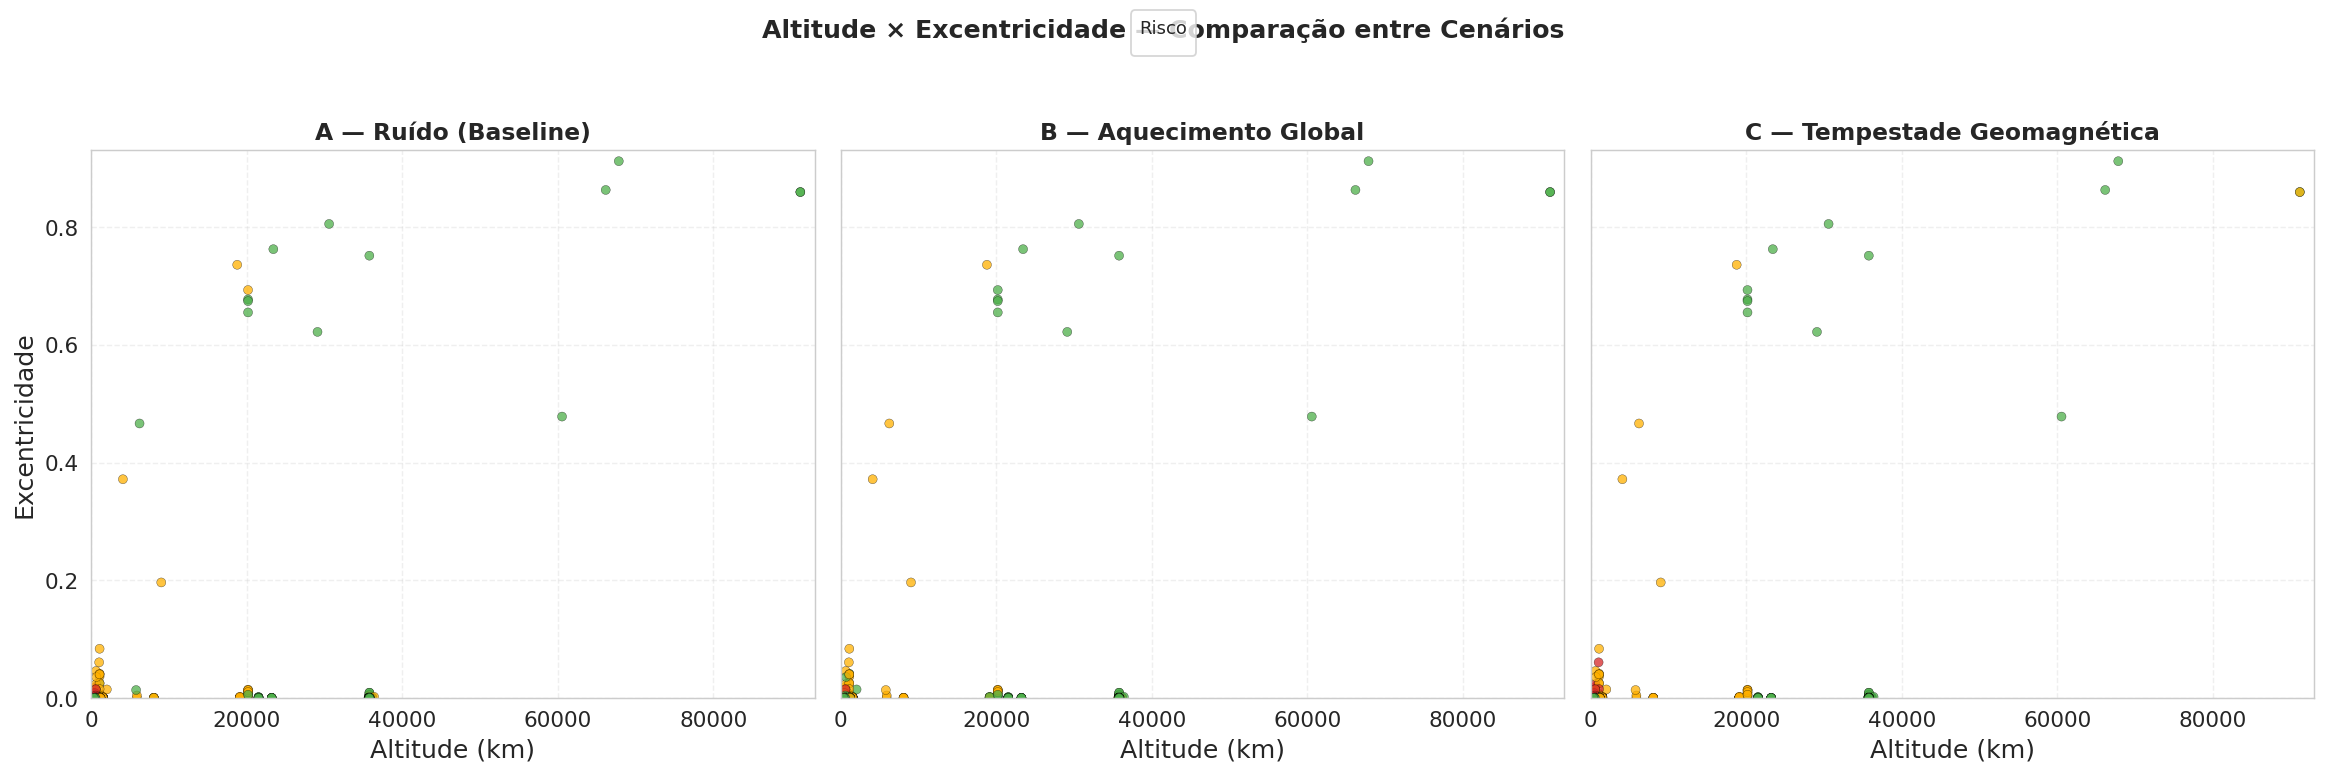

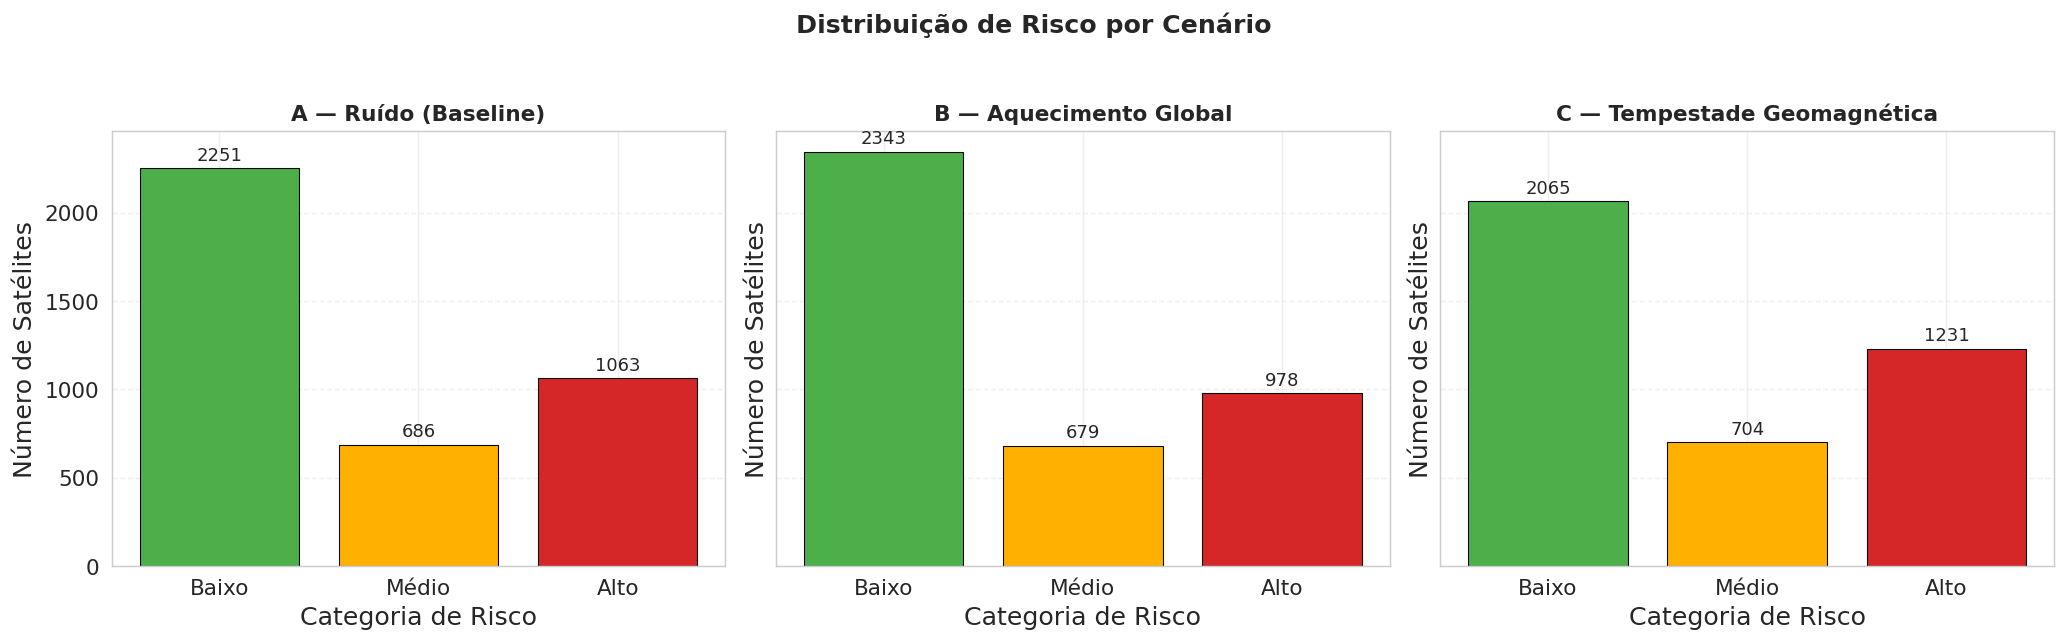

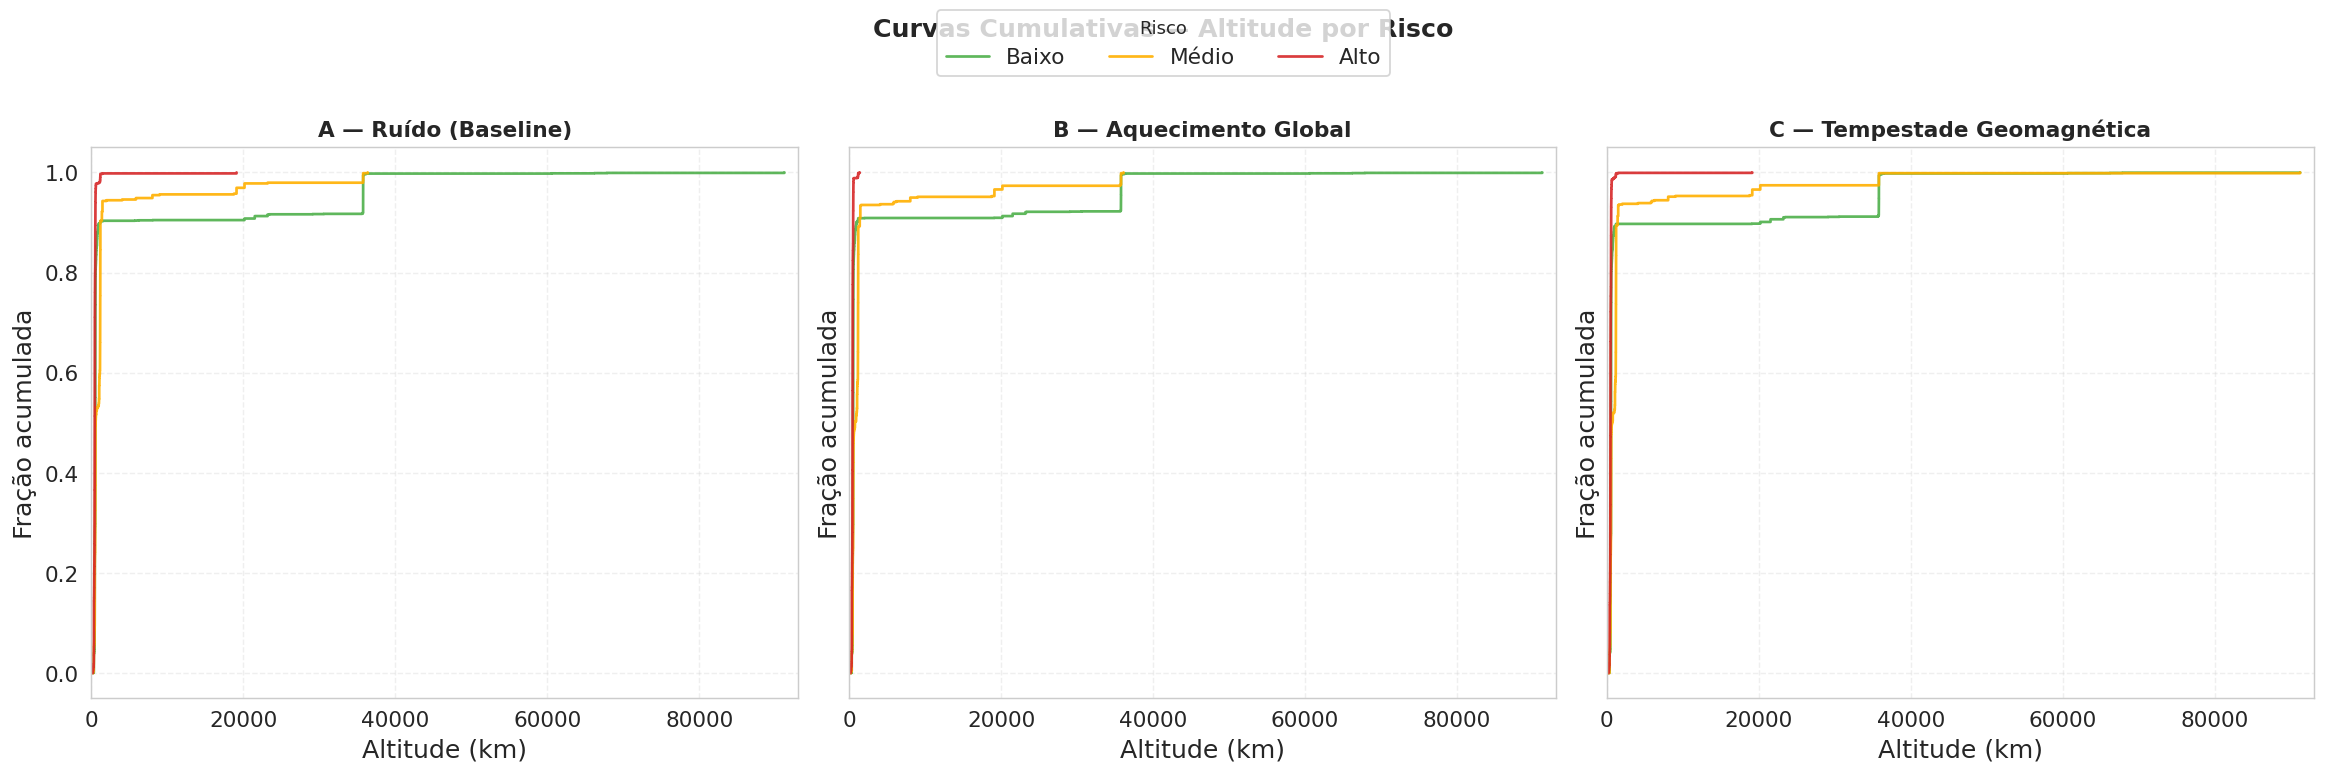

Figuras salvas em:
- /content/comparativo_disp_alt_ecc_risco_A_B_C.png
- /content/comparativo_hist_risco_A_B_C.png
- /content/comparativo_cdf_altitude_por_risco_A_B_C.png
Tabela salva em: /content/resumo_risco_por_cenario.csv


In [ ]:
# MÓDULO 9 — GRÁFICOS ORBITAIS COMPARATIVOS (A × B × C)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

sns.set_style("whitegrid")
plt.rcParams['figure.dpi'] = 130

palette_risco = {
    'Baixo': '#4daf4a',
    'Médio': '#ffb000',
    'Alto': '#d62728'
}

def amostrar_df(df_in, nmax=4000, seed=42):
    if len(df_in) > nmax:
        return df_in.sample(n=nmax, random_state=seed)
    return df_in

bases = {
    'A — Ruído (Baseline)': df_ruido[['ALTITUDE_KM','ECCENTRICITY','RISCO']].dropna(),
    'B — Aquecimento Global': df_aquec[['ALTITUDE_KM','ECCENTRICITY','RISCO']].dropna(),
    'C — Tempestade Geomagnética': df_tempestade[['ALTITUDE_KM','ECCENTRICITY','RISCO']].dropna(),
}

for k in bases.keys():
    bases[k] = amostrar_df(bases[k])

alt_min = min(b['ALTITUDE_KM'].min() for b in bases.values())
alt_max = max(b['ALTITUDE_KM'].max() for b in bases.values())
ecc_min = min(b['ECCENTRICITY'].min() for b in bases.values())
ecc_max = max(b['ECCENTRICITY'].max() for b in bases.values())

alt_pad = 0.02 * (alt_max - alt_min)
ecc_pad = 0.02 * (ecc_max - ecc_min)

xlim = (max(0, alt_min - alt_pad), alt_max + alt_pad)
ylim = (max(0, ecc_min - ecc_pad), min(1.0, ecc_max + ecc_pad))

# Dispersões
fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharex=True, sharey=True)

for ax, (titulo, df_plot) in zip(axes, bases.items()):
    sns.scatterplot(
        data=df_plot,
        x='ALTITUDE_KM',
        y='ECCENTRICITY',
        hue='RISCO',
        palette=palette_risco,
        alpha=0.75,
        s=25,
        linewidth=0.2,
        edgecolor='black',
        ax=ax,
        legend=False
    )
    ax.set_title(titulo, fontsize=13, fontweight='bold')
    ax.set_xlabel('Altitude (km)')
    ax.set_ylabel('Excentricidade')
    ax.set_xlim(*xlim)
    ax.set_ylim(*ylim)
    ax.grid(alpha=0.3, linestyle='--')

handles, labels = axes[0].get_legend_handles_labels()
fig.legend(
    handles, ['Baixo','Médio','Alto'],
    title='Risco',
    loc='upper center',
    ncol=3,
    frameon=True
)

fig.suptitle('Altitude × Excentricidade — Comparação entre Cenários',
             fontsize=14, y=0.98, fontweight='bold')

plt.tight_layout(rect=[0,0,1,0.93])
plt.savefig(f"{PASTA_SAIDA}/comparativo_disp_alt_ecc_risco_A_B_C.png",
            dpi=200, bbox_inches='tight')
plt.show()

# Histogramas
fig, axes = plt.subplots(1, 3, figsize=(16, 5), sharey=True)
ordem = ['Baixo','Médio','Alto']

for ax, (titulo, df_plot) in zip(axes, bases.items()):
    cont = df_plot['RISCO'].value_counts().reindex(ordem).fillna(0).astype(int)
    barra = ax.bar(
        ordem,
        cont.values,
        color=[palette_risco[o] for o in ordem],
        edgecolor='black',
        linewidth=0.6
    )
    ax.set_title(titulo, fontsize=12, fontweight='bold')
    ax.set_xlabel('Categoria de Risco')
    ax.set_ylabel('Número de Satélites')
    ax.grid(alpha=0.3, axis='y', linestyle='--')

    for rect, val in zip(barra, cont.values):
        ax.text(
            rect.get_x() + rect.get_width()/2,
            rect.get_height() + max(cont.values) * 0.01,
            f'{val}',
            ha='center',
            va='bottom',
            fontsize=10
        )

fig.suptitle('Distribuição de Risco por Cenário',
             fontsize=14, y=0.98, fontweight='bold')

plt.tight_layout(rect=[0,0,1,0.94])
plt.savefig(f"{PASTA_SAIDA}/comparativo_hist_risco_A_B_C.png",
            dpi=200, bbox_inches='tight')
plt.show()

# Curvas CDF
fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True, sharex=True)

for ax, (titulo, df_plot) in zip(axes, bases.items()):
    for r, cor in palette_risco.items():
        dados = df_plot[df_plot['RISCO'] == r]['ALTITUDE_KM'].dropna().sort_values().values
        if len(dados) == 0:
            continue
        y = np.linspace(0, 1, len(dados), endpoint=True)
        ax.step(dados, y, where='post', color=cor, alpha=0.9, label=r)
    ax.set_title(titulo, fontsize=12, fontweight='bold')
    ax.set_xlabel('Altitude (km)')
    ax.set_ylabel('Fração acumulada')
    ax.set_xlim(*xlim)
    ax.grid(alpha=0.3, linestyle='--')

handles, labels = axes[0].get_legend_handles_labels()

fig.legend(handles, labels, title='Risco', loc='upper center',
           ncol=3, frameon=True)

fig.suptitle('Curvas Cumulativas — Altitude por Risco',
             fontsize=14, y=0.98, fontweight='bold')

plt.tight_layout(rect=[0,0,1,0.93])
plt.savefig(f"{PASTA_SAIDA}/comparativo_cdf_altitude_por_risco_A_B_C.png",
            dpi=200, bbox_inches='tight')
plt.show()

# Exportação das tabelas-resumo
resumos = []

for nome, d in bases.items():
    cont = d['RISCO'].value_counts().reindex(ordem).fillna(0).astype(int)
    resumo = pd.DataFrame({
        'Cenário': [nome]*3,
        'Risco': ordem,
        'Contagem': cont.values
    })
    resumos.append(resumo)

resumo_risco = pd.concat(resumos, ignore_index=True)
resumo_risco.to_csv(f"{PASTA_SAIDA}/resumo_risco_por_cenario.csv", index=False)

print("Figuras salvas em:")
print(f"- {PASTA_SAIDA}/comparativo_disp_alt_ecc_risco_A_B_C.png")
print(f"- {PASTA_SAIDA}/comparativo_hist_risco_A_B_C.png")
print(f"- {PASTA_SAIDA}/comparativo_cdf_altitude_por_risco_A_B_C.png")
print(f"Tabela salva em: {PASTA_SAIDA}/resumo_risco_por_cenario.csv")


In [ ]:
# MÓDULO 10 — MAPA DE CALOR GLOBAL DE RISCO ORBITAL (FUNDO CINZA)

import folium
from folium.plugins import HeatMap
import numpy as np
import pandas as pd
import sys, os
from IPython.display import display

# Carregar base e classificar risco
CAMINHO_CSV = '/content/drive/MyDrive/Aeroespacial/active_satellites.csv'

if not os.path.exists(CAMINHO_CSV):
    print(f"Arquivo nao encontrado: {CAMINHO_CSV}")
    sys.exit()

df = pd.read_csv(CAMINHO_CSV)
print(f"CSV carregado: {len(df):,} registros")

ALTITUDE_COLUMN = 'ALTITUDE_KM'
if ALTITUDE_COLUMN in df.columns:
    df['RISCO_NOME'] = np.where(df[ALTITUDE_COLUMN] < 300, 'ALTO',
                               np.where(df[ALTITUDE_COLUMN] < 500, 'MEDIO', 'BAIXO'))
elif 'MEAN_MOTION' in df.columns:
    df['RISCO_NOME'] = np.where(df['MEAN_MOTION'] > 15.5, 'ALTO',
                               np.where(df['MEAN_MOTION'] > 14, 'MEDIO', 'BAIXO'))
else:
    print("ERRO: Colunas de altitude ou movimento medio nao encontradas.")
    sys.exit()

risco_map = {'ALTO': 3, 'MEDIO': 2, 'BAIXO': 1}
df['RISCO_NUM'] = df['RISCO_NOME'].map(risco_map)

print("Distribuicao:", df['RISCO_NOME'].value_counts().to_dict())

# Simulação de posições
np.random.seed(42)
df['LONGITUDE_SIMULADA'] = np.random.uniform(-180, 180, len(df))
df['LATITUDE_SIMULADA'] = np.clip(df['INCLINATION'] * np.sign(np.random.randn(len(df))), -90, 90)

df_risco = df[df['RISCO_NOME'].isin(['ALTO', 'MEDIO'])].copy()
df_risco['PESO_RISCO'] = df_risco['RISCO_NUM'].map({3: 2.0, 2: 1.0})
df_risco = df_risco.dropna(subset=['LATITUDE_SIMULADA', 'LONGITUDE_SIMULADA', 'PESO_RISCO'])

heatmap_data = df_risco[['LATITUDE_SIMULADA', 'LONGITUDE_SIMULADA', 'PESO_RISCO']].values.tolist()

if not heatmap_data:
    print("Nenhum dado disponivel para o mapa de calor.")
    sys.exit()

print(f"Dados prontos para o mapa: {len(heatmap_data):,} pontos validos")

# Mapa base
m = folium.Map(
    location=[0, 0],
    zoom_start=2,
    min_zoom=1,
    max_zoom=5,
    tiles='CartoDB positron',
    attr='OpenStreetMap contributors | CartoDB Positron'
)

# Heatmap
HeatMap(
    data=heatmap_data,
    radius=9,
    blur=13,
    min_opacity=0.4,
    max_zoom=3,
    gradient={
        0.0: '#004d40',
        0.4: '#ffeb3b',
        0.7: '#ff7043',
        1.0: '#d50000'
    }
).add_to(m)

# Salvamento
mapa_arquivo = '/content/mapa_risco_global_cinza.html'
m.save(mapa_arquivo)

print(f"Mapa salvo como: {mapa_arquivo}")
print("Fundo cinza melhora o contraste das cores de risco.")
display(m)


CSV carregado: 12,810 registros
Distribuicao: {'MEDIO': 9852, 'BAIXO': 1883, 'ALTO': 1075}
Dados prontos para o mapa: 10,927 pontos validos
Mapa salvo como: /content/mapa_risco_global_cinza.html
Fundo cinza melhora o contraste das cores de risco.


In [ ]:
# CÉLULA A — Parâmetros e funções auxiliares

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

# Cálculo de altitude caso não exista
if 'ALTITUDE_KM' not in df.columns:
    MU = 3.986004418e14
    R_E = 6378137.0
    SEG_POR_DIA = 86400

    def _semi_eixo(n_rev_dia):
        if pd.isna(n_rev_dia) or n_rev_dia <= 0:
            return np.nan
        n_rad_s = n_rev_dia * 2*np.pi/SEG_POR_DIA
        return (MU/(n_rad_s**2))**(1/3)

    def _h_perigeu(a_m, e):
        if pd.isna(a_m) or pd.isna(e):
            return np.nan
        return (a_m*(1 - e) - R_E)/1000.0

    df['SEMI_EIXO_MAIOR_M'] = df['MEAN_MOTION'].apply(_semi_eixo)
    df['ALTITUDE_KM'] = df.apply(
        lambda r: _h_perigeu(r['SEMI_EIXO_MAIOR_M'], r.get('ECCENTRICITY', np.nan)),
        axis=1
    )

# ABS_BSTAR
if 'ABS_BSTAR' not in df.columns and 'BSTAR' in df.columns:
    df['ABS_BSTAR'] = df['BSTAR'].abs()

# Seleção LEO
ALT_MAX_KM = 1200
df_sim = df.dropna(subset=['ALTITUDE_KM','ABS_BSTAR']).copy()
df_sim = df_sim[(df_sim['ALTITUDE_KM'] > 120) & (df_sim['ALTITUDE_KM'] <= ALT_MAX_KM)].copy()
df_sim.reset_index(drop=True, inplace=True)

print(f"Conjunto para simulação: {len(df_sim)} satélites em 120–{ALT_MAX_KM} km.")

# Tempo
DURA_H = 72
DT_H = 1.0
N_STEPS = int(DURA_H/DT_H) + 1
t_h = np.arange(N_STEPS) * DT_H

# Perfil sintético de Kp
def perfil_kp_sintetico(t_h):
    kp = np.zeros_like(t_h, dtype=float)
    for i, th in enumerate(t_h):
        if th < 12:
            kp[i] = 2.0
        elif th < 24:
            kp[i] = 2.0 + (7.0-2.0)*(th-12.0)/12.0
        elif th < 36:
            kp[i] = 7.5
        else:
            kp[i] = 3.0 + (7.5-3.0)*np.exp(-(th-36.0)/10.0)
    return np.clip(kp, 0, 9)

kp_t = perfil_kp_sintetico(t_h)

# Fatores de densidade
def fator_temporal_por_kp(kp):
    a0, a1 = 0.0, 0.10
    return np.power(10.0, a0 + a1*kp) / np.power(10.0, a0 + a1*2.0)

def fator_altitude(h_km, h0=200.0, H=60.0):
    val = np.exp(-(np.maximum(h_km, 0) - h0)/H)
    return np.clip(val, 0.05, None)

f_t = fator_temporal_por_kp(kp_t)

# Parâmetro global
K_DECAY = 1.0e5

print("Parâmetros prontos.")


Conjunto para simulação: 11594 satélites em 120–1200 km.
Parâmetros prontos.


Resumo da perda total de altitude (km):
count    11594.000
mean       275.228
std        220.555
min          0.000
25%         45.172
50%        274.049
75%        481.880
max       1196.721
Name: DELTA_ALT_KM, dtype: float64


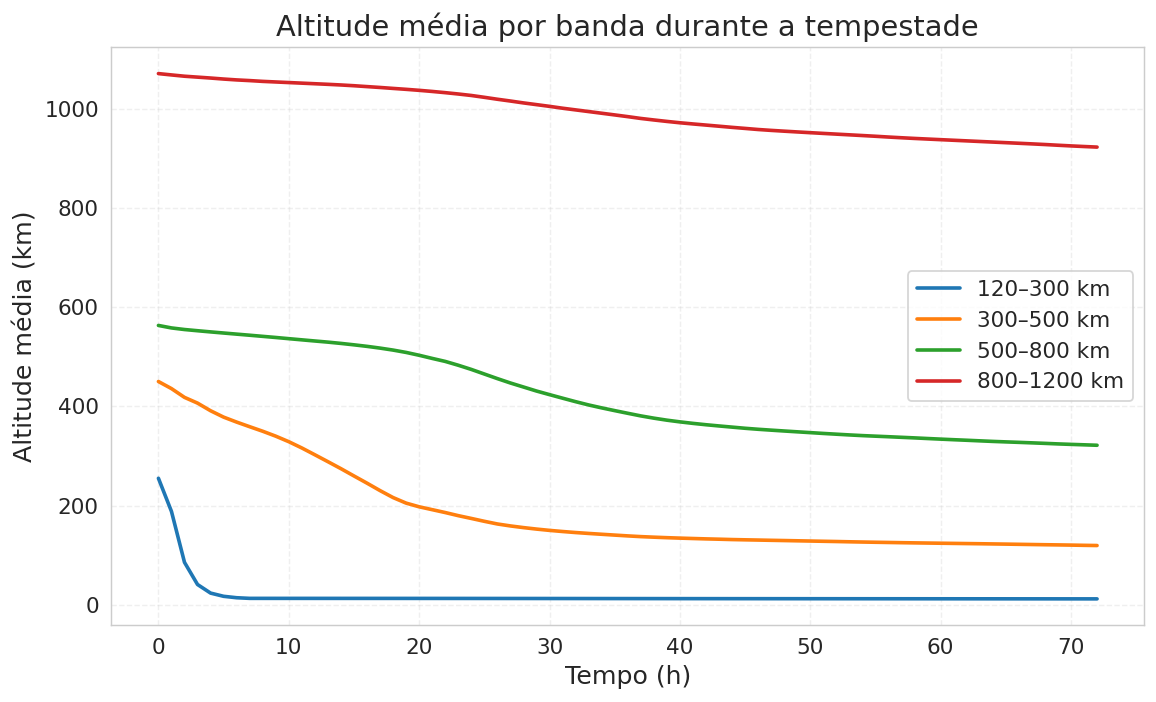

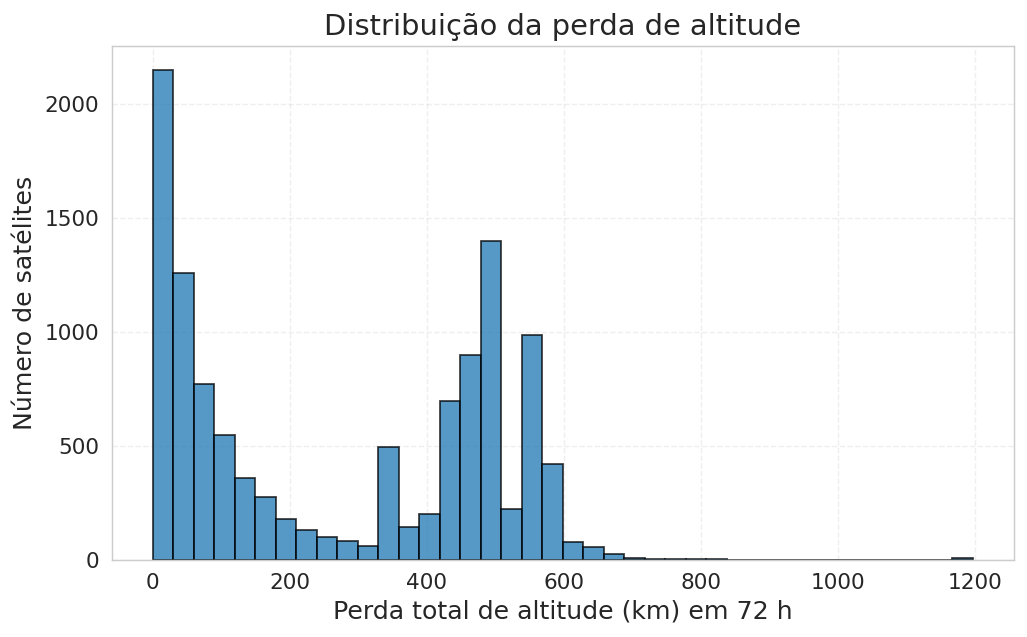

Tabela dos 20 mais afetados salva em /content/figuras_artigo/choque_arrasto_top20.csv


In [ ]:
# CÉLULA B — Integração numérica da altitude

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Estado inicial
h0 = df_sim['ALTITUDE_KM'].values.astype(float)
bstar = df_sim['ABS_BSTAR'].values.astype(float)

# Integração
h_t = np.zeros((len(h0), len(t_h)), dtype=float)
h_t[:, 0] = h0

for k in range(len(t_h)-1):
    fh = fator_altitude(h_t[:, k])
    dh = K_DECAY * bstar * f_t[k] * fh * DT_H
    h_t[:, k+1] = np.maximum(0.0, h_t[:, k] - dh)

# Resultados
delta_total = h_t[:, 0] - h_t[:, -1]
df_result = df_sim[['OBJECT_NAME','ALTITUDE_KM','ABS_BSTAR','INCLINATION','ECCENTRICITY','MEAN_MOTION']].copy()
df_result['DELTA_ALT_KM'] = delta_total
df_result['ALT_FINAL_KM'] = h_t[:, -1]

print("Resumo da perda total de altitude (km):")
print(df_result['DELTA_ALT_KM'].describe().round(3))

# Bandas de altitude
bins = [120, 300, 500, 800, 1200]
labels = ["120–300 km","300–500 km","500–800 km","800–1200 km"]
df_result['BANDA_ALT_INI'] = pd.cut(df_result['ALTITUDE_KM'], bins=bins, labels=labels, include_lowest=True)

# Médias por banda
medias_por_banda = {}
for banda in labels:
    idx = df_result['BANDA_ALT_INI'] == banda
    if idx.any():
        medias_por_banda[banda] = h_t[idx.values, :].mean(axis=0)

# Gráfico: séries temporais
plt.figure(figsize=(9,5.5))
for banda, serie in medias_por_banda.items():
    plt.plot(t_h, serie, label=banda, lw=2)
plt.xlabel('Tempo (h)')
plt.ylabel('Altitude média (km)')
plt.title('Altitude média por banda durante a tempestade')
plt.grid(True, alpha=0.3, linestyle='--')
plt.legend()
plt.tight_layout()
plt.savefig(f"{output_dir}/choque_arrasto_series_medias_por_banda.png", dpi=200)
plt.show()

# Histograma
plt.figure(figsize=(8,5))
plt.hist(df_result['DELTA_ALT_KM'], bins=40, edgecolor='black', alpha=0.75)
plt.xlabel('Perda total de altitude (km) em 72 h')
plt.ylabel('Número de satélites')
plt.title('Distribuição da perda de altitude')
plt.grid(True, alpha=0.3, linestyle='--')
plt.tight_layout()
plt.savefig(f"{output_dir}/choque_arrasto_hist_delta_total.png", dpi=200)
plt.show()

# Exportação dos mais afetados
topN = 20
top_afetados = df_result.sort_values('DELTA_ALT_KM', ascending=False).head(topN)
top_afetados.to_csv(f"{output_dir}/choque_arrasto_top{topN}.csv", index=False)

print(f"Tabela dos {topN} mais afetados salva em {output_dir}/choque_arrasto_top{topN}.csv")


Resumo da diferença de altitude final (tempestade - calmo) [km]:
count    11594.000
mean       -46.013
std         98.392
min       -725.613
25%        -37.427
50%         -6.235
75%          0.000
max          0.000
Name: DELTA_EXTRA_ALT_FINAL, dtype: float64


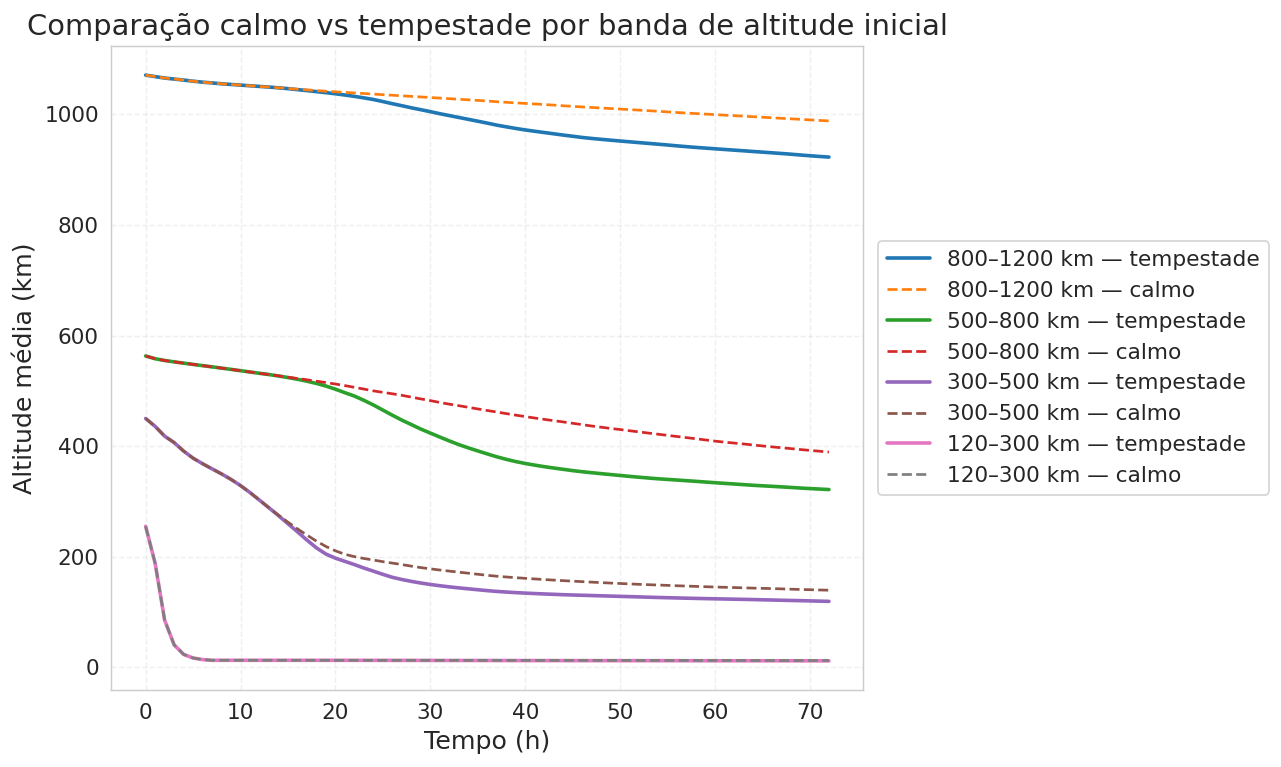

In [ ]:
# CÉLULA C — Comparação entre tempestade e dia calmo

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

f_t_calm = np.ones_like(t_h)

h_calm = np.zeros((len(h0), len(t_h)), dtype=float)
h_calm[:, 0] = h0

for k in range(len(t_h)-1):
    fh = fator_altitude(h_calm[:, k])
    dh = K_DECAY * bstar * f_t_calm[k] * fh * DT_H
    h_calm[:, k+1] = np.maximum(0.0, h_calm[:, k] - dh)

delta_total_calm = h_calm[:, 0] - h_calm[:, -1]

df_comp = df_result.copy()
df_comp['DELTA_ALT_CALMO'] = delta_total_calm
df_comp['ALT_FINAL_CALMO'] = h_calm[:, -1]
df_comp['DELTA_EXTRA_ALT_FINAL'] = df_comp['ALT_FINAL_KM'] - df_comp['ALT_FINAL_CALMO']

print("Resumo da diferença de altitude final (tempestade - calmo) [km]:")
print(df_comp['DELTA_EXTRA_ALT_FINAL'].describe().round(3))

# Gráfico comparação
plt.figure(figsize=(10,6))
for banda in df_result['BANDA_ALT_INI'].dropna().unique():
    idx = (df_result['BANDA_ALT_INI'] == banda).values
    if idx.any():
        plt.plot(t_h, h_t[idx, :].mean(axis=0), label=f"{banda} — tempestade", lw=2)
        plt.plot(t_h, h_calm[idx, :].mean(axis=0), label=f"{banda} — calmo", lw=1.5, linestyle='--')
plt.xlabel('Tempo (h)')
plt.ylabel('Altitude média (km)')
plt.title('Comparação calmo vs tempestade por banda de altitude inicial')
plt.grid(True, alpha=0.3, linestyle='--')
plt.legend(
    bbox_to_anchor=(1.02, 0.5),
    loc='center left',
    borderaxespad=0.,
    frameon=True
)
plt.tight_layout()
plt.savefig(f"{output_dir}/choque_arrasto_series_calmo_vs_tempestade.png", dpi=200)
plt.show()

df_comp.to_csv(f"{output_dir}/choque_arrasto_comparativo_por_satelite.csv", index=False)


In [ ]:

# Estatísticas consolidadas dos modelos e classificações orbitais e tabela latex

import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

def pct(x):
    return f"{100*x:.1f}".replace(".", ",")

padroes = {
    "Estados Unidos (USA)": ["USA","STARLINK","GPS","NAVSTAR","GOES","LANDSAT","SPACEX","IRIDIUM"],
    "Rússia": ["COSMOS","GLONASS","MOLNIYA"],
    "China": ["BEIDOU","GAOFEN","SHIJIAN","YAOGAN"],
    "Japão": ["HIMAWARI","QZSS","ALOS"],
    "Europa": ["GALILEO","SENTINEL","METOP","EUTELSAT"],
    "Índia": ["INSAT","IRNSS","CARTOSAT","GSAT"],
    "Outros": []
}

def pais_obj(o):
    u = str(o).upper()
    for p, lst in padroes.items():
        if any(k in u for k in lst):
            return p
    return "Outros"

df["PAIS"] = df["OBJECT_NAME"].apply(pais_obj)

def regime(n):
    if pd.isna(n): return "HEO"
    if 0.99 <= n <= 1.01: return "GEO"
    if 2 <= n < 11: return "MEO"
    if n >= 11: return "LEO"
    return "HEO"

df["_REGIME"] = df["MEAN_MOTION"].apply(regime)

pais_dist = (
    df["PAIS"].value_counts(normalize=True)
      .sort_values(ascending=False)
      .apply(pct)
)
pais_linha = " ; ".join([f"{k}: {v}\\%" for k,v in pais_dist.items()])

orb_dist = (
    df["_REGIME"].value_counts(normalize=True)
      .sort_values(ascending=False)
      .apply(pct)
)
orbita_linha = " ; ".join([f"{k}: {v}\\%" for k,v in orb_dist.items()])

risco_dist = (
    df_ruido["RISCO"].value_counts(normalize=True)
      .sort_values(ascending=False)
      .apply(pct)
)
risco_linha = " ; ".join([f"{k}: {v}\\%" for k,v in risco_dist.items()])

feats_km = ["INCLINATION", "MEAN_MOTION", "ECCENTRICITY", "RA_OF_ASC_NODE"]
df_km = df.dropna(subset=feats_km).copy()
idx_km = df_km.index

scaler = StandardScaler()
X_km = scaler.fit_transform(df_km[feats_km])

km_model = KMeans(n_clusters=4, random_state=42, n_init=10)
labels_km = km_model.fit_predict(X_km)

df["cluster_km"] = np.nan
df.loc[idx_km, "cluster_km"] = labels_km

kmeans_dist = (
    df.dropna(subset=["cluster_km"])
      .groupby("cluster_km").size()
      .div(len(df.dropna(subset=["cluster_km"])))
      .sort_index()
)

kmeans_linha = " ; ".join(
    [f"C{c}: {pct(kmeans_dist[c])}\\%" for c in kmeans_dist.index]
)

anom = df["is_anomalia"].sum() if "is_anomalia" in df.columns else 0
pct_anom = pct(anom / len(df))
iso_linha = f"{anom} anomalias detectadas ({pct_anom}\\%)"

rf_atual = f"Acurácia: {pct(resA['acc'])}\\% ; F1: {pct(resA['f1'])}"
rf_aquec = f"Acurácia: {pct(resB['acc'])}\\% ; F1: {pct(resB['f1'])}"
rf_temp  = f"Acurácia: {pct(resC['acc'])}\\% ; F1: {pct(resC['f1'])}"

importancia_linha = resA["latex"]

tabela = {
    "Total de Satélites": f"{len(df):,}".replace(",", "."),
    "Distribuição por País": pais_linha,
    "Faixa Orbital (Módulo 5)": orbita_linha,
    "Risco Heurístico": risco_linha,
    "Clusters (K-Means, k=4)": kmeans_linha,
    "Anomalias (IsolationForest)": iso_linha,
    "RF — Cenário Atual": rf_atual,
    "RF — Aquecimento Global": rf_aquec,
    "RF — Tempestade Geomagnética": rf_temp,
    "Importância das Variáveis (RF)": importancia_linha,
}

def latex_table(d):
    out = []
    out.append(r"\newcommand{\tabeladesempenhoauto}{")
    out.append(r"\begin{table}[ht]")
    out.append(r"\centering")
    out.append(r"\caption{Desempenho e Estatísticas Reais dos Modelos}")
    out.append(r"\begin{tabular}{|m{6cm}|m{9cm}|}")
    out.append(r"\hline")
    out.append(r"\textbf{Indicador} & \textbf{Valor Observado} \\")
    out.append(r"\hline")
    for k,v in d.items():
        out.append(f"{k} & {v} \\\\")
        out.append(r"\hline")
    out.append(r"\end{tabular}")
    out.append(r"\end{table}")
    out.append("}")
    return "\n".join(out)

print(latex_table(tabela))


\newcommand{\tabeladesempenhoauto}{
\begin{table}[ht]
\centering
\caption{Desempenho e Estatísticas Reais dos Modelos}
\begin{tabular}{|m{6cm}|m{9cm}|}
\hline
\textbf{Indicador} & \textbf{Valor Observado} \\
\hline
Total de Satélites & 12.810 \\
\hline
Distribuição por País & Estados Unidos (USA): 67,5\% ; Outros: 28,0\% ; China: 2,5\% ; Rússia: 1,0\% ; Europa: 0,6\% ; Índia: 0,4\% ; Japão: 0,0\% \\
\hline
Faixa Orbital (Módulo 5) & LEO: 93,7\% ; GEO: 4,5\% ; MEO: 1,0\% ; HEO: 0,7\% \\
\hline
Risco Heurístico & Baixo: 55,4\% ; Alto: 27,6\% ; Médio: 17,0\% \\
\hline
Clusters (K-Means, k=4) & C0.0: 48,6\% ; C1.0: 5,9\% ; C2.0: 45,2\% ; C3.0: 0,3\% \\
\hline
Anomalias (IsolationForest) & 0 anomalias detectadas (0,0\%) \\
\hline
RF — Cenário Atual & Acurácia: 89,8\% ; F1: 87,7 \\
\hline
RF — Aquecimento Global & Acurácia: 90,1\% ; F1: 88,1 \\
\hline
RF — Tempestade Geomagnética & Acurácia: 89,8\% ; F1: 88,4 \\
\hline
Importância das Variáveis (RF) & Importância das Variáveis (RF) & ABS_BST

In [ ]:
# Parte final — Geração da Tabela LaTeX com Estatísticas Reais do Pipeline Orbital

import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest

def pct(x):
    return f"{100*x:.1f}".replace(".", ",")

padroes = {
    "Estados Unidos (USA)": ["USA","STARLINK","GPS","NAVSTAR","GOES","LANDSAT","SPACEX","IRIDIUM"],
    "Rússia": ["COSMOS","GLONASS","MOLNIYA"],
    "China": ["BEIDOU","GAOFEN","SHIJIAN","YAOGAN"],
    "Japão": ["HIMAWARI","QZSS","ALOS"],
    "Europa": ["GALILEO","SENTINEL","METOP","EUTELSAT"],
    "Índia": ["INSAT","IRNSS","CARTOSAT","GSAT"],
    "Outros": []
}

def pais_obj(o):
    u = str(o).upper()
    for p, lst in padroes.items():
        if any(k in u for k in lst):
            return p
    return "Outros"

df["PAIS"] = df["OBJECT_NAME"].apply(pais_obj)

def regime(n):
    if pd.isna(n): return "HEO"
    if 0.99 <= n <= 1.01: return "GEO"
    if 2 <= n < 11: return "MEO"
    if n >= 11: return "LEO"
    return "HEO"

df["_REGIME"] = df["MEAN_MOTION"].apply(regime)

pais_dist = (
    df["PAIS"].value_counts(normalize=True)
      .sort_values(ascending=False)
      .apply(pct)
)
pais_linha = " ; ".join([f"{k}: {v}\\%" for k,v in pais_dist.items()])

orb_dist = (
    df["_REGIME"].value_counts(normalize=True)
      .sort_values(ascending=False)
      .apply(pct)
)
orbita_linha = " ; ".join([f"{k}: {v}\\%" for k,v in orb_dist.items()])

risco_dist = (
    df_ruido["RISCO"].value_counts(normalize=True)
      .sort_values(ascending=False)
      .apply(pct)
)
risco_linha = " ; ".join([f"{k}: {v}\\%" for k,v in risco_dist.items()])

feats_km = ["INCLINATION", "MEAN_MOTION", "ECCENTRICITY", "RA_OF_ASC_NODE"]
df_km = df.dropna(subset=feats_km).copy()
idx_km = df_km.index

scaler = StandardScaler()
X_km = scaler.fit_transform(df_km[feats_km])

km_model = KMeans(n_clusters=4, random_state=42, n_init=10)
labels_km = km_model.fit_predict(X_km)

df["cluster_km"] = np.nan
df.loc[idx_km, "cluster_km"] = labels_km

kmeans_dist = (
    df.dropna(subset=["cluster_km"])
      .groupby("cluster_km").size()
      .div(len(df.dropna(subset=["cluster_km"])))
      .sort_index()
)

kmeans_linha = " ; ".join([f"C{c}: {pct(kmeans_dist[c])}\\%" for c in kmeans_dist.index])

feats_if = ["INCLINATION", "MEAN_MOTION", "ECCENTRICITY", "BSTAR", "ALTITUDE_KM"]
df_if = df.dropna(subset=feats_if).copy()

scaler_if = StandardScaler()
X_if = scaler_if.fit_transform(df_if[feats_if])

iso_model = IsolationForest(contamination=0.10, random_state=42)
anom_labels = iso_model.fit_predict(X_if)

df["is_anomalia"] = 0
df.loc[df_if.index, "is_anomalia"] = (anom_labels == -1).astype(int)

anom = df["is_anomalia"].sum()
pct_anom = pct(anom / len(df))
iso_linha = f"{anom} anomalias detectadas ({pct_anom}\\%)"

rf_atual = f"Acurácia: {pct(resA['acc'])}\\% ; F1: {pct(resA['f1'])}"
rf_aquec = f"Acurácia: {pct(resB['acc'])}\\% ; F1: {pct(resB['f1'])}"
rf_temp  = f"Acurácia: {pct(resC['acc'])}\\% ; F1: {pct(resC['f1'])}"

importancia_linha = resA["latex"]

tabela = {
    "Total de Satélites": f"{len(df):,}".replace(",", "."),
    "Distribuição por País": pais_linha,
    "Faixa Orbital (Módulo 5)": orbita_linha,
    "Risco Heurístico": risco_linha,
    "Clusters (K-Means, k=4)": kmeans_linha,
    "Anomalias (IsolationForest)": iso_linha,
    "RF — Cenário Atual": rf_atual,
    "RF — Aquecimento Global": rf_aquec,
    "RF — Tempestade Geomagnética": rf_temp,
    "Importância das Variáveis (RF)": importancia_linha,
}

def latex_table(d):
    out = []
    out.append(r"\newcommand{\tabeladesempenhoauto}{")
    out.append(r"\begin{table}[ht]")
    out.append(r"\centering")
    out.append(r"\caption{Desempenho e Estatísticas Reais dos Modelos}")
    out.append(r"\begin{tabular}{|m{6cm}|m{9cm}|}")
    out.append(r"\hline")
    out.append(r"\textbf{Indicador} & \textbf{Valor Observado} \\")
    out.append(r"\hline")
    for k,v in d.items():
        out.append(f"{k} & {v} \\\\")
        out.append(r"\hline")
    out.append(r"\end{tabular}")
    out.append(r"\end{table}")
    out.append("}")
    return "\n".join(out)

print(latex_table(tabela))


\newcommand{\tabeladesempenhoauto}{
\begin{table}[ht]
\centering
\caption{Desempenho e Estatísticas Reais dos Modelos}
\begin{tabular}{|m{6cm}|m{9cm}|}
\hline
\textbf{Indicador} & \textbf{Valor Observado} \\
\hline
Total de Satélites & 12.810 \\
\hline
Distribuição por País & Estados Unidos (USA): 67,5\% ; Outros: 28,0\% ; China: 2,5\% ; Rússia: 1,0\% ; Europa: 0,6\% ; Índia: 0,4\% ; Japão: 0,0\% \\
\hline
Faixa Orbital (Módulo 5) & LEO: 93,7\% ; GEO: 4,5\% ; MEO: 1,0\% ; HEO: 0,7\% \\
\hline
Risco Heurístico & Baixo: 55,4\% ; Alto: 27,6\% ; Médio: 17,0\% \\
\hline
Clusters (K-Means, k=4) & C0.0: 48,6\% ; C1.0: 5,9\% ; C2.0: 45,2\% ; C3.0: 0,3\% \\
\hline
Anomalias (IsolationForest) & 1281 anomalias detectadas (10,0\%) \\
\hline
RF — Cenário Atual & Acurácia: 89,8\% ; F1: 87,7 \\
\hline
RF — Aquecimento Global & Acurácia: 90,1\% ; F1: 88,1 \\
\hline
RF — Tempestade Geomagnética & Acurácia: 89,8\% ; F1: 88,4 \\
\hline
Importância das Variáveis (RF) & Importância das Variáveis (RF) & ABS